In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


1/8 [==>...........................] - ETA: 33s - loss: 0.1256 - STD: 1.9931e-04 - MAE: 0.3412

2/8 [======>.......................] - ETA: 1s - loss: 0.0721 - STD: 4.7518e-04 - MAE: 0.2307 

3/8 [==========>...................] - ETA: 0s - loss: 0.0516 - STD: 5.1177e-04 - MAE: 0.1790

4/8 [==============>...............] - ETA: 5s - loss: 0.0437 - STD: 4.7328e-04 - MAE: 0.1596

5/8 [=================>............] - ETA: 3s - loss: 0.0396 - STD: 4.2385e-04 - MAE: 0.1520

6/8 [=====================>........] - ETA: 1s - loss: 0.0373 - STD: 3.7867e-04 - MAE: 0.1488

7/8 [=========================>....] - ETA: 0s - loss: 0.0360 - STD: 3.4024e-04 - MAE: 0.1474

8/8 [==============================] - ETA: 0s - loss: 0.0352 - STD: 3.0804e-04 - MAE: 0.1468

8/8 [==============================] - 11s 876ms/step - loss: 0.0352 - STD: 3.0804e-04 - MAE: 0.1468 - val_loss: 0.0284 - val_STD: 4.1958e-05 - val_MAE: 0.1590


Epoch 2/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0294 - STD: 6.4743e-05 - MAE: 0.1428

2/8 [======>.......................] - ETA: 3s - loss: 0.0290 - STD: 5.8783e-05 - MAE: 0.1415

3/8 [==========>...................] - ETA: 3s - loss: 0.0287 - STD: 5.4140e-05 - MAE: 0.1404

4/8 [==============>...............] - ETA: 2s - loss: 0.0282 - STD: 5.0613e-05 - MAE: 0.1386

5/8 [=================>............] - ETA: 1s - loss: 0.0275 - STD: 4.8142e-05 - MAE: 0.1364

6/8 [=====================>........] - ETA: 1s - loss: 0.0268 - STD: 4.6628e-05 - MAE: 0.1337

7/8 [=========================>....] - ETA: 0s - loss: 0.0260 - STD: 4.5950e-05 - MAE: 0.1306

8/8 [==============================] - ETA: 0s - loss: 0.0250 - STD: 4.6053e-05 - MAE: 0.1270

8/8 [==============================] - 6s 688ms/step - loss: 0.0250 - STD: 4.6053e-05 - MAE: 0.1270 - val_loss: 0.0147 - val_STD: 2.7176e-05 - val_MAE: 0.1022


Epoch 3/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0156 - STD: 5.2291e-05 - MAE: 0.0922

2/8 [======>.......................] - ETA: 3s - loss: 0.0143 - STD: 5.5516e-05 - MAE: 0.0874

3/8 [==========>...................] - ETA: 3s - loss: 0.0132 - STD: 5.8526e-05 - MAE: 0.0836

4/8 [==============>...............] - ETA: 2s - loss: 0.0123 - STD: 6.1290e-05 - MAE: 0.0812

5/8 [=================>............] - ETA: 1s - loss: 0.0117 - STD: 6.3556e-05 - MAE: 0.0800

6/8 [=====================>........] - ETA: 1s - loss: 0.0113 - STD: 6.5250e-05 - MAE: 0.0801

7/8 [=========================>....] - ETA: 0s - loss: 0.0113 - STD: 6.6310e-05 - MAE: 0.0811

8/8 [==============================] - ETA: 0s - loss: 0.0114 - STD: 6.6697e-05 - MAE: 0.0827

8/8 [==============================] - 5s 662ms/step - loss: 0.0114 - STD: 6.6697e-05 - MAE: 0.0827 - val_loss: 0.0123 - val_STD: 3.0947e-05 - val_MAE: 0.0726


Epoch 4/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0127 - STD: 6.4516e-05 - MAE: 0.0967

2/8 [======>.......................] - ETA: 3s - loss: 0.0128 - STD: 6.1719e-05 - MAE: 0.0970

3/8 [==========>...................] - ETA: 3s - loss: 0.0126 - STD: 5.9167e-05 - MAE: 0.0963

4/8 [==============>...............] - ETA: 2s - loss: 0.0124 - STD: 5.6959e-05 - MAE: 0.0949

5/8 [=================>............] - ETA: 1s - loss: 0.0120 - STD: 5.5281e-05 - MAE: 0.0931

6/8 [=====================>........] - ETA: 1s - loss: 0.0116 - STD: 5.4125e-05 - MAE: 0.0911

7/8 [=========================>....] - ETA: 0s - loss: 0.0113 - STD: 5.3371e-05 - MAE: 0.0891

8/8 [==============================] - ETA: 0s - loss: 0.0111 - STD: 5.2966e-05 - MAE: 0.0874

8/8 [==============================] - 5s 660ms/step - loss: 0.0111 - STD: 5.2966e-05 - MAE: 0.0874 - val_loss: 0.0087 - val_STD: 3.5983e-05 - val_MAE: 0.0655


Epoch 5/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0094 - STD: 5.1336e-05 - MAE: 0.0741

2/8 [======>.......................] - ETA: 3s - loss: 0.0095 - STD: 5.2159e-05 - MAE: 0.0740

3/8 [==========>...................] - ETA: 3s - loss: 0.0096 - STD: 5.2823e-05 - MAE: 0.0741

4/8 [==============>...............] - ETA: 2s - loss: 0.0097 - STD: 5.3456e-05 - MAE: 0.0741

5/8 [=================>............] - ETA: 1s - loss: 0.0098 - STD: 5.4073e-05 - MAE: 0.0742

6/8 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 5.4729e-05 - MAE: 0.0743

7/8 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 5.5479e-05 - MAE: 0.0743

8/8 [==============================] - ETA: 0s - loss: 0.0099 - STD: 5.6261e-05 - MAE: 0.0743

8/8 [==============================] - 5s 665ms/step - loss: 0.0099 - STD: 5.6261e-05 - MAE: 0.0743 - val_loss: 0.0091 - val_STD: 4.4997e-05 - val_MAE: 0.0693


Epoch 6/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0099 - STD: 6.3594e-05 - MAE: 0.0741

2/8 [======>.......................] - ETA: 3s - loss: 0.0097 - STD: 6.4750e-05 - MAE: 0.0740

3/8 [==========>...................] - ETA: 3s - loss: 0.0096 - STD: 6.5953e-05 - MAE: 0.0741

4/8 [==============>...............] - ETA: 2s - loss: 0.0095 - STD: 6.7120e-05 - MAE: 0.0741

5/8 [=================>............] - ETA: 1s - loss: 0.0095 - STD: 6.8372e-05 - MAE: 0.0744

6/8 [=====================>........] - ETA: 1s - loss: 0.0094 - STD: 6.9504e-05 - MAE: 0.0747

7/8 [=========================>....] - ETA: 0s - loss: 0.0094 - STD: 7.0728e-05 - MAE: 0.0751

8/8 [==============================] - ETA: 0s - loss: 0.0094 - STD: 7.1945e-05 - MAE: 0.0755

8/8 [==============================] - 5s 662ms/step - loss: 0.0094 - STD: 7.1945e-05 - MAE: 0.0755 - val_loss: 0.0089 - val_STD: 5.7848e-05 - val_MAE: 0.0626


Epoch 7/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0095 - STD: 8.2529e-05 - MAE: 0.0788

2/8 [======>.......................] - ETA: 3s - loss: 0.0095 - STD: 8.3769e-05 - MAE: 0.0789

3/8 [==========>...................] - ETA: 3s - loss: 0.0095 - STD: 8.4958e-05 - MAE: 0.0791

4/8 [==============>...............] - ETA: 2s - loss: 0.0095 - STD: 8.6183e-05 - MAE: 0.0790

5/8 [=================>............] - ETA: 1s - loss: 0.0095 - STD: 8.7349e-05 - MAE: 0.0787

6/8 [=====================>........] - ETA: 1s - loss: 0.0094 - STD: 8.8435e-05 - MAE: 0.0784

7/8 [=========================>....] - ETA: 0s - loss: 0.0094 - STD: 8.9485e-05 - MAE: 0.0781

8/8 [==============================] - ETA: 0s - loss: 0.0094 - STD: 9.0549e-05 - MAE: 0.0778

8/8 [==============================] - 6s 702ms/step - loss: 0.0094 - STD: 9.0549e-05 - MAE: 0.0778 - val_loss: 0.0086 - val_STD: 6.9827e-05 - val_MAE: 0.0636


Epoch 8/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0092 - STD: 9.9905e-05 - MAE: 0.0749

2/8 [======>.......................] - ETA: 4s - loss: 0.0092 - STD: 1.0086e-04 - MAE: 0.0748

3/8 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 1.0186e-04 - MAE: 0.0747

4/8 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.0293e-04 - MAE: 0.0745

5/8 [=================>............] - ETA: 1s - loss: 0.0093 - STD: 1.0411e-04 - MAE: 0.0745

6/8 [=====================>........] - ETA: 1s - loss: 0.0093 - STD: 1.0535e-04 - MAE: 0.0744

7/8 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 1.0668e-04 - MAE: 0.0744

8/8 [==============================] - ETA: 0s - loss: 0.0093 - STD: 1.0798e-04 - MAE: 0.0744

8/8 [==============================] - 6s 683ms/step - loss: 0.0093 - STD: 1.0798e-04 - MAE: 0.0744 - val_loss: 0.0086 - val_STD: 8.4452e-05 - val_MAE: 0.0642


Epoch 9/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0092 - STD: 1.2069e-04 - MAE: 0.0745

2/8 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.2259e-04 - MAE: 0.0747

3/8 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 1.2440e-04 - MAE: 0.0748

4/8 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.2627e-04 - MAE: 0.0749

5/8 [=================>............] - ETA: 2s - loss: 0.0092 - STD: 1.2817e-04 - MAE: 0.0751

6/8 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 1.3002e-04 - MAE: 0.0752

7/8 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.3184e-04 - MAE: 0.0754

8/8 [==============================] - ETA: 0s - loss: 0.0092 - STD: 1.3372e-04 - MAE: 0.0755

8/8 [==============================] - 6s 752ms/step - loss: 0.0092 - STD: 1.3372e-04 - MAE: 0.0755 - val_loss: 0.0086 - val_STD: 1.0474e-04 - val_MAE: 0.0627


Epoch 10/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0091 - STD: 1.5052e-04 - MAE: 0.0759

2/8 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.5219e-04 - MAE: 0.0762

3/8 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 1.5399e-04 - MAE: 0.0761

4/8 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.5574e-04 - MAE: 0.0760

5/8 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 1.5759e-04 - MAE: 0.0760

6/8 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 1.5950e-04 - MAE: 0.0759

7/8 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.6128e-04 - MAE: 0.0758

8/8 [==============================] - ETA: 0s - loss: 0.0092 - STD: 1.6316e-04 - MAE: 0.0757

8/8 [==============================] - 6s 697ms/step - loss: 0.0092 - STD: 1.6316e-04 - MAE: 0.0757 - val_loss: 0.0086 - val_STD: 1.2532e-04 - val_MAE: 0.0636


Epoch 11/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0093 - STD: 1.8041e-04 - MAE: 0.0753

2/8 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.8227e-04 - MAE: 0.0749

3/8 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 1.8454e-04 - MAE: 0.0750

4/8 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.8679e-04 - MAE: 0.0750

5/8 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 1.8925e-04 - MAE: 0.0749

6/8 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 1.9178e-04 - MAE: 0.0750

7/8 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.9434e-04 - MAE: 0.0749

8/8 [==============================] - ETA: 0s - loss: 0.0092 - STD: 1.9701e-04 - MAE: 0.0749

8/8 [==============================] - 6s 710ms/step - loss: 0.0092 - STD: 1.9701e-04 - MAE: 0.0749 - val_loss: 0.0086 - val_STD: 1.5355e-04 - val_MAE: 0.0632


Epoch 12/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0092 - STD: 2.2139e-04 - MAE: 0.0752

2/8 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 2.2481e-04 - MAE: 0.0754

3/8 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 2.2776e-04 - MAE: 0.0755

4/8 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 2.3091e-04 - MAE: 0.0755

5/8 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 2.3406e-04 - MAE: 0.0756

6/8 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 2.3715e-04 - MAE: 0.0755

7/8 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 2.4039e-04 - MAE: 0.0755

8/8 [==============================] - ETA: 0s - loss: 0.0092 - STD: 2.4345e-04 - MAE: 0.0755

8/8 [==============================] - 6s 708ms/step - loss: 0.0092 - STD: 2.4345e-04 - MAE: 0.0755 - val_loss: 0.0086 - val_STD: 1.8895e-04 - val_MAE: 0.0631


Epoch 13/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0092 - STD: 2.7340e-04 - MAE: 0.0755

2/8 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 2.7656e-04 - MAE: 0.0755

3/8 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 2.8037e-04 - MAE: 0.0753

4/8 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 2.8434e-04 - MAE: 0.0753

5/8 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 2.8805e-04 - MAE: 0.0753

6/8 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 2.9183e-04 - MAE: 0.0753

7/8 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 2.9572e-04 - MAE: 0.0753

8/8 [==============================] - ETA: 0s - loss: 0.0092 - STD: 2.9973e-04 - MAE: 0.0752

8/8 [==============================] - 6s 703ms/step - loss: 0.0092 - STD: 2.9973e-04 - MAE: 0.0752 - val_loss: 0.0086 - val_STD: 2.3340e-04 - val_MAE: 0.0633


Epoch 14/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0092 - STD: 3.3739e-04 - MAE: 0.0749

2/8 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 3.4284e-04 - MAE: 0.0750

3/8 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 3.4811e-04 - MAE: 0.0751

4/8 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 3.5326e-04 - MAE: 0.0751

5/8 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 3.5874e-04 - MAE: 0.0751

6/8 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 3.6438e-04 - MAE: 0.0752

7/8 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 3.6987e-04 - MAE: 0.0752

8/8 [==============================] - ETA: 0s - loss: 0.0092 - STD: 3.7573e-04 - MAE: 0.0752

8/8 [==============================] - 6s 701ms/step - loss: 0.0092 - STD: 3.7573e-04 - MAE: 0.0752 - val_loss: 0.0086 - val_STD: 2.9524e-04 - val_MAE: 0.0631


Epoch 15/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0092 - STD: 4.2852e-04 - MAE: 0.0752

2/8 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 4.3513e-04 - MAE: 0.0754

3/8 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 4.4189e-04 - MAE: 0.0753

4/8 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 4.4885e-04 - MAE: 0.0753

5/8 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 4.5635e-04 - MAE: 0.0753

6/8 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 4.6357e-04 - MAE: 0.0753

7/8 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 4.7125e-04 - MAE: 0.0753

8/8 [==============================] - ETA: 0s - loss: 0.0092 - STD: 4.7923e-04 - MAE: 0.0753

8/8 [==============================] - 6s 715ms/step - loss: 0.0092 - STD: 4.7923e-04 - MAE: 0.0753 - val_loss: 0.0086 - val_STD: 3.7839e-04 - val_MAE: 0.0631


Epoch 16/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0091 - STD: 5.5278e-04 - MAE: 0.0751

2/8 [======>.......................] - ETA: 3s - loss: 0.0091 - STD: 5.6087e-04 - MAE: 0.0751

3/8 [==========>...................] - ETA: 3s - loss: 0.0091 - STD: 5.7019e-04 - MAE: 0.0751

4/8 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 5.7974e-04 - MAE: 0.0751

5/8 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 5.9003e-04 - MAE: 0.0751

6/8 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 6.0081e-04 - MAE: 0.0752

7/8 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 6.1172e-04 - MAE: 0.0751

8/8 [==============================] - ETA: 0s - loss: 0.0092 - STD: 6.2298e-04 - MAE: 0.0751

8/8 [==============================] - 6s 721ms/step - loss: 0.0092 - STD: 6.2298e-04 - MAE: 0.0751 - val_loss: 0.0085 - val_STD: 4.9835e-04 - val_MAE: 0.0630


Epoch 17/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0091 - STD: 7.2645e-04 - MAE: 0.0751

2/8 [======>.......................] - ETA: 3s - loss: 0.0091 - STD: 7.4076e-04 - MAE: 0.0752

3/8 [==========>...................] - ETA: 3s - loss: 0.0091 - STD: 7.5446e-04 - MAE: 0.0752

4/8 [==============>...............] - ETA: 2s - loss: 0.0091 - STD: 7.6861e-04 - MAE: 0.0752

5/8 [=================>............] - ETA: 1s - loss: 0.0091 - STD: 7.8449e-04 - MAE: 0.0751

6/8 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 8.0009e-04 - MAE: 0.0752

7/8 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 8.1645e-04 - MAE: 0.0752

8/8 [==============================] - ETA: 0s - loss: 0.0091 - STD: 8.3309e-04 - MAE: 0.0752

8/8 [==============================] - 6s 693ms/step - loss: 0.0091 - STD: 8.3309e-04 - MAE: 0.0752 - val_loss: 0.0085 - val_STD: 6.7280e-04 - val_MAE: 0.0629


Epoch 18/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0091 - STD: 9.8192e-04 - MAE: 0.0750

2/8 [======>.......................] - ETA: 4s - loss: 0.0092 - STD: 0.0010 - MAE: 0.0752    

3/8 [==========>...................] - ETA: 3s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0751

4/8 [==============>...............] - ETA: 2s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0750

5/8 [=================>............] - ETA: 1s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0750

6/8 [=====================>........] - ETA: 1s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0750

7/8 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0750

8/8 [==============================] - ETA: 0s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0750

8/8 [==============================] - 6s 695ms/step - loss: 0.0091 - STD: 0.0011 - MAE: 0.0750 - val_loss: 0.0085 - val_STD: 9.3639e-04 - val_MAE: 0.0628


Epoch 19/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0092 - STD: 0.0014 - MAE: 0.0754

2/8 [======>.......................] - ETA: 3s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0751

3/8 [==========>...................] - ETA: 3s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0751

4/8 [==============>...............] - ETA: 2s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0750

5/8 [=================>............] - ETA: 1s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0750

6/8 [=====================>........] - ETA: 1s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0750

7/8 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0016 - MAE: 0.0749

8/8 [==============================] - ETA: 0s - loss: 0.0091 - STD: 0.0016 - MAE: 0.0749

8/8 [==============================] - 6s 680ms/step - loss: 0.0091 - STD: 0.0016 - MAE: 0.0749 - val_loss: 0.0084 - val_STD: 0.0014 - val_MAE: 0.0625


Epoch 20/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0090 - STD: 0.0020 - MAE: 0.0747

2/8 [======>.......................] - ETA: 3s - loss: 0.0090 - STD: 0.0020 - MAE: 0.0747

3/8 [==========>...................] - ETA: 3s - loss: 0.0090 - STD: 0.0021 - MAE: 0.0748

4/8 [==============>...............] - ETA: 2s - loss: 0.0090 - STD: 0.0021 - MAE: 0.0748

5/8 [=================>............] - ETA: 1s - loss: 0.0090 - STD: 0.0022 - MAE: 0.0748

6/8 [=====================>........] - ETA: 1s - loss: 0.0090 - STD: 0.0023 - MAE: 0.0748

7/8 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.0023 - MAE: 0.0747

8/8 [==============================] - ETA: 0s - loss: 0.0090 - STD: 0.0024 - MAE: 0.0747

8/8 [==============================] - 6s 681ms/step - loss: 0.0090 - STD: 0.0024 - MAE: 0.0747 - val_loss: 0.0084 - val_STD: 0.0020 - val_MAE: 0.0622


Epoch 21/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0089 - STD: 0.0030 - MAE: 0.0744

2/8 [======>.......................] - ETA: 3s - loss: 0.0089 - STD: 0.0031 - MAE: 0.0744

3/8 [==========>...................] - ETA: 3s - loss: 0.0089 - STD: 0.0032 - MAE: 0.0744

4/8 [==============>...............] - ETA: 2s - loss: 0.0089 - STD: 0.0032 - MAE: 0.0744

5/8 [=================>............] - ETA: 1s - loss: 0.0089 - STD: 0.0033 - MAE: 0.0744

6/8 [=====================>........] - ETA: 1s - loss: 0.0089 - STD: 0.0034 - MAE: 0.0743

7/8 [=========================>....] - ETA: 0s - loss: 0.0089 - STD: 0.0035 - MAE: 0.0743

8/8 [==============================] - ETA: 0s - loss: 0.0089 - STD: 0.0036 - MAE: 0.0743

8/8 [==============================] - 6s 678ms/step - loss: 0.0089 - STD: 0.0036 - MAE: 0.0743 - val_loss: 0.0082 - val_STD: 0.0031 - val_MAE: 0.0616


Epoch 22/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0088 - STD: 0.0046 - MAE: 0.0740

2/8 [======>.......................] - ETA: 3s - loss: 0.0088 - STD: 0.0048 - MAE: 0.0741

3/8 [==========>...................] - ETA: 3s - loss: 0.0088 - STD: 0.0049 - MAE: 0.0741

4/8 [==============>...............] - ETA: 2s - loss: 0.0088 - STD: 0.0051 - MAE: 0.0741

5/8 [=================>............] - ETA: 1s - loss: 0.0088 - STD: 0.0052 - MAE: 0.0740

6/8 [=====================>........] - ETA: 1s - loss: 0.0088 - STD: 0.0054 - MAE: 0.0740

7/8 [=========================>....] - ETA: 0s - loss: 0.0088 - STD: 0.0055 - MAE: 0.0739

8/8 [==============================] - ETA: 0s - loss: 0.0088 - STD: 0.0057 - MAE: 0.0738

8/8 [==============================] - 6s 680ms/step - loss: 0.0088 - STD: 0.0057 - MAE: 0.0738 - val_loss: 0.0080 - val_STD: 0.0049 - val_MAE: 0.0607


Epoch 23/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0086 - STD: 0.0073 - MAE: 0.0731

2/8 [======>.......................] - ETA: 3s - loss: 0.0086 - STD: 0.0076 - MAE: 0.0731

3/8 [==========>...................] - ETA: 2s - loss: 0.0086 - STD: 0.0078 - MAE: 0.0732

4/8 [==============>...............] - ETA: 2s - loss: 0.0086 - STD: 0.0080 - MAE: 0.0731

5/8 [=================>............] - ETA: 1s - loss: 0.0086 - STD: 0.0083 - MAE: 0.0731

6/8 [=====================>........] - ETA: 1s - loss: 0.0086 - STD: 0.0085 - MAE: 0.0730

7/8 [=========================>....] - ETA: 0s - loss: 0.0085 - STD: 0.0088 - MAE: 0.0730

8/8 [==============================] - ETA: 0s - loss: 0.0085 - STD: 0.0090 - MAE: 0.0729

8/8 [==============================] - 6s 700ms/step - loss: 0.0085 - STD: 0.0090 - MAE: 0.0729 - val_loss: 0.0078 - val_STD: 0.0076 - val_MAE: 0.0594


Epoch 24/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0083 - STD: 0.0116 - MAE: 0.0721

2/8 [======>.......................] - ETA: 3s - loss: 0.0083 - STD: 0.0119 - MAE: 0.0722

3/8 [==========>...................] - ETA: 3s - loss: 0.0083 - STD: 0.0122 - MAE: 0.0721

4/8 [==============>...............] - ETA: 2s - loss: 0.0083 - STD: 0.0125 - MAE: 0.0720

5/8 [=================>............] - ETA: 1s - loss: 0.0083 - STD: 0.0129 - MAE: 0.0720

6/8 [=====================>........] - ETA: 1s - loss: 0.0082 - STD: 0.0132 - MAE: 0.0719

7/8 [=========================>....] - ETA: 0s - loss: 0.0082 - STD: 0.0136 - MAE: 0.0718

8/8 [==============================] - ETA: 0s - loss: 0.0082 - STD: 0.0140 - MAE: 0.0717

8/8 [==============================] - 6s 710ms/step - loss: 0.0082 - STD: 0.0140 - MAE: 0.0717 - val_loss: 0.0074 - val_STD: 0.0115 - val_MAE: 0.0579


Epoch 25/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0080 - STD: 0.0175 - MAE: 0.0708

2/8 [======>.......................] - ETA: 3s - loss: 0.0080 - STD: 0.0179 - MAE: 0.0708

3/8 [==========>...................] - ETA: 3s - loss: 0.0080 - STD: 0.0183 - MAE: 0.0709

4/8 [==============>...............] - ETA: 2s - loss: 0.0080 - STD: 0.0188 - MAE: 0.0707

5/8 [=================>............] - ETA: 1s - loss: 0.0079 - STD: 0.0192 - MAE: 0.0705

6/8 [=====================>........] - ETA: 1s - loss: 0.0079 - STD: 0.0197 - MAE: 0.0705

7/8 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.0201 - MAE: 0.0704

8/8 [==============================] - ETA: 0s - loss: 0.0079 - STD: 0.0206 - MAE: 0.0703

8/8 [==============================] - 6s 723ms/step - loss: 0.0079 - STD: 0.0206 - MAE: 0.0703 - val_loss: 0.0071 - val_STD: 0.0160 - val_MAE: 0.0563


Epoch 26/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0077 - STD: 0.0246 - MAE: 0.0694

2/8 [======>.......................] - ETA: 3s - loss: 0.0076 - STD: 0.0251 - MAE: 0.0692

3/8 [==========>...................] - ETA: 3s - loss: 0.0076 - STD: 0.0256 - MAE: 0.0692

4/8 [==============>...............] - ETA: 2s - loss: 0.0076 - STD: 0.0260 - MAE: 0.0692

5/8 [=================>............] - ETA: 1s - loss: 0.0076 - STD: 0.0265 - MAE: 0.0692

6/8 [=====================>........] - ETA: 1s - loss: 0.0076 - STD: 0.0269 - MAE: 0.0691

7/8 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.0273 - MAE: 0.0690

8/8 [==============================] - ETA: 0s - loss: 0.0076 - STD: 0.0278 - MAE: 0.0690

8/8 [==============================] - 6s 680ms/step - loss: 0.0076 - STD: 0.0278 - MAE: 0.0690 - val_loss: 0.0069 - val_STD: 0.0200 - val_MAE: 0.0552


Epoch 27/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0075 - STD: 0.0315 - MAE: 0.0686

2/8 [======>.......................] - ETA: 3s - loss: 0.0075 - STD: 0.0319 - MAE: 0.0683

3/8 [==========>...................] - ETA: 2s - loss: 0.0074 - STD: 0.0322 - MAE: 0.0682

4/8 [==============>...............] - ETA: 2s - loss: 0.0074 - STD: 0.0326 - MAE: 0.0681

5/8 [=================>............] - ETA: 1s - loss: 0.0074 - STD: 0.0329 - MAE: 0.0681

6/8 [=====================>........] - ETA: 1s - loss: 0.0074 - STD: 0.0332 - MAE: 0.0680

7/8 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.0335 - MAE: 0.0679

8/8 [==============================] - ETA: 0s - loss: 0.0074 - STD: 0.0338 - MAE: 0.0679

8/8 [==============================] - 6s 676ms/step - loss: 0.0074 - STD: 0.0338 - MAE: 0.0679 - val_loss: 0.0067 - val_STD: 0.0226 - val_MAE: 0.0546


Epoch 28/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0073 - STD: 0.0363 - MAE: 0.0672

2/8 [======>.......................] - ETA: 3s - loss: 0.0073 - STD: 0.0365 - MAE: 0.0673

3/8 [==========>...................] - ETA: 2s - loss: 0.0073 - STD: 0.0367 - MAE: 0.0673

4/8 [==============>...............] - ETA: 2s - loss: 0.0073 - STD: 0.0369 - MAE: 0.0673

5/8 [=================>............] - ETA: 1s - loss: 0.0073 - STD: 0.0371 - MAE: 0.0673

6/8 [=====================>........] - ETA: 1s - loss: 0.0073 - STD: 0.0372 - MAE: 0.0672

7/8 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.0374 - MAE: 0.0671

8/8 [==============================] - ETA: 0s - loss: 0.0073 - STD: 0.0375 - MAE: 0.0670

8/8 [==============================] - 6s 675ms/step - loss: 0.0073 - STD: 0.0375 - MAE: 0.0670 - val_loss: 0.0066 - val_STD: 0.0239 - val_MAE: 0.0542


Epoch 29/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0072 - STD: 0.0388 - MAE: 0.0665

2/8 [======>.......................] - ETA: 3s - loss: 0.0072 - STD: 0.0388 - MAE: 0.0667

3/8 [==========>...................] - ETA: 3s - loss: 0.0072 - STD: 0.0389 - MAE: 0.0665

4/8 [==============>...............] - ETA: 2s - loss: 0.0072 - STD: 0.0390 - MAE: 0.0665

5/8 [=================>............] - ETA: 1s - loss: 0.0072 - STD: 0.0392 - MAE: 0.0664

6/8 [=====================>........] - ETA: 1s - loss: 0.0072 - STD: 0.0393 - MAE: 0.0664

7/8 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.0394 - MAE: 0.0664

8/8 [==============================] - ETA: 0s - loss: 0.0072 - STD: 0.0395 - MAE: 0.0664

8/8 [==============================] - 6s 677ms/step - loss: 0.0072 - STD: 0.0395 - MAE: 0.0664 - val_loss: 0.0066 - val_STD: 0.0249 - val_MAE: 0.0538


Epoch 30/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0071 - STD: 0.0403 - MAE: 0.0661

2/8 [======>.......................] - ETA: 3s - loss: 0.0071 - STD: 0.0404 - MAE: 0.0660

3/8 [==========>...................] - ETA: 3s - loss: 0.0071 - STD: 0.0404 - MAE: 0.0660

4/8 [==============>...............] - ETA: 2s - loss: 0.0071 - STD: 0.0405 - MAE: 0.0661

5/8 [=================>............] - ETA: 1s - loss: 0.0071 - STD: 0.0406 - MAE: 0.0660

6/8 [=====================>........] - ETA: 1s - loss: 0.0071 - STD: 0.0406 - MAE: 0.0660

7/8 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0407 - MAE: 0.0659

8/8 [==============================] - ETA: 0s - loss: 0.0071 - STD: 0.0408 - MAE: 0.0659

8/8 [==============================] - 6s 673ms/step - loss: 0.0071 - STD: 0.0408 - MAE: 0.0659 - val_loss: 0.0065 - val_STD: 0.0259 - val_MAE: 0.0533


Epoch 31/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0071 - STD: 0.0415 - MAE: 0.0658

2/8 [======>.......................] - ETA: 3s - loss: 0.0071 - STD: 0.0414 - MAE: 0.0656

3/8 [==========>...................] - ETA: 3s - loss: 0.0070 - STD: 0.0415 - MAE: 0.0655

4/8 [==============>...............] - ETA: 2s - loss: 0.0070 - STD: 0.0415 - MAE: 0.0654

5/8 [=================>............] - ETA: 2s - loss: 0.0070 - STD: 0.0416 - MAE: 0.0654

6/8 [=====================>........] - ETA: 1s - loss: 0.0070 - STD: 0.0416 - MAE: 0.0654

7/8 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0416 - MAE: 0.0654

8/8 [==============================] - ETA: 0s - loss: 0.0070 - STD: 0.0416 - MAE: 0.0654

8/8 [==============================] - 6s 719ms/step - loss: 0.0070 - STD: 0.0416 - MAE: 0.0654 - val_loss: 0.0064 - val_STD: 0.0265 - val_MAE: 0.0528


Epoch 32/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0070 - STD: 0.0419 - MAE: 0.0651

2/8 [======>.......................] - ETA: 3s - loss: 0.0069 - STD: 0.0419 - MAE: 0.0650

3/8 [==========>...................] - ETA: 3s - loss: 0.0069 - STD: 0.0419 - MAE: 0.0650

4/8 [==============>...............] - ETA: 2s - loss: 0.0070 - STD: 0.0419 - MAE: 0.0649

5/8 [=================>............] - ETA: 1s - loss: 0.0069 - STD: 0.0420 - MAE: 0.0648

6/8 [=====================>........] - ETA: 1s - loss: 0.0069 - STD: 0.0420 - MAE: 0.0648

7/8 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0421 - MAE: 0.0648

8/8 [==============================] - ETA: 0s - loss: 0.0069 - STD: 0.0421 - MAE: 0.0648

8/8 [==============================] - 6s 680ms/step - loss: 0.0069 - STD: 0.0421 - MAE: 0.0648 - val_loss: 0.0063 - val_STD: 0.0271 - val_MAE: 0.0522


Epoch 33/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0069 - STD: 0.0426 - MAE: 0.0646

2/8 [======>.......................] - ETA: 4s - loss: 0.0069 - STD: 0.0427 - MAE: 0.0645

3/8 [==========>...................] - ETA: 3s - loss: 0.0069 - STD: 0.0427 - MAE: 0.0644

4/8 [==============>...............] - ETA: 2s - loss: 0.0069 - STD: 0.0427 - MAE: 0.0644

5/8 [=================>............] - ETA: 1s - loss: 0.0069 - STD: 0.0428 - MAE: 0.0643

6/8 [=====================>........] - ETA: 1s - loss: 0.0068 - STD: 0.0428 - MAE: 0.0643

7/8 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0429 - MAE: 0.0642

8/8 [==============================] - ETA: 0s - loss: 0.0068 - STD: 0.0429 - MAE: 0.0642

8/8 [==============================] - 6s 704ms/step - loss: 0.0068 - STD: 0.0429 - MAE: 0.0642 - val_loss: 0.0062 - val_STD: 0.0276 - val_MAE: 0.0516


Epoch 34/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0068 - STD: 0.0432 - MAE: 0.0638

2/8 [======>.......................] - ETA: 3s - loss: 0.0067 - STD: 0.0433 - MAE: 0.0636

3/8 [==========>...................] - ETA: 3s - loss: 0.0067 - STD: 0.0434 - MAE: 0.0635

4/8 [==============>...............] - ETA: 2s - loss: 0.0067 - STD: 0.0434 - MAE: 0.0633

5/8 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.0435 - MAE: 0.0633

6/8 [=====================>........] - ETA: 1s - loss: 0.0067 - STD: 0.0435 - MAE: 0.0633

7/8 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0435 - MAE: 0.0632

8/8 [==============================] - ETA: 0s - loss: 0.0066 - STD: 0.0436 - MAE: 0.0632

8/8 [==============================] - 5s 667ms/step - loss: 0.0066 - STD: 0.0436 - MAE: 0.0632 - val_loss: 0.0060 - val_STD: 0.0278 - val_MAE: 0.0508


Epoch 35/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0065 - STD: 0.0442 - MAE: 0.0627

2/8 [======>.......................] - ETA: 3s - loss: 0.0065 - STD: 0.0443 - MAE: 0.0627

3/8 [==========>...................] - ETA: 3s - loss: 0.0065 - STD: 0.0443 - MAE: 0.0625

4/8 [==============>...............] - ETA: 2s - loss: 0.0065 - STD: 0.0443 - MAE: 0.0622

5/8 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.0444 - MAE: 0.0621

6/8 [=====================>........] - ETA: 1s - loss: 0.0064 - STD: 0.0445 - MAE: 0.0620

7/8 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0446 - MAE: 0.0619

8/8 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0447 - MAE: 0.0619

8/8 [==============================] - 6s 676ms/step - loss: 0.0064 - STD: 0.0447 - MAE: 0.0619 - val_loss: 0.0057 - val_STD: 0.0290 - val_MAE: 0.0501


Epoch 36/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0062 - STD: 0.0456 - MAE: 0.0609

2/8 [======>.......................] - ETA: 3s - loss: 0.0062 - STD: 0.0457 - MAE: 0.0609

3/8 [==========>...................] - ETA: 2s - loss: 0.0062 - STD: 0.0458 - MAE: 0.0608

4/8 [==============>...............] - ETA: 2s - loss: 0.0062 - STD: 0.0459 - MAE: 0.0606

5/8 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.0460 - MAE: 0.0604

6/8 [=====================>........] - ETA: 1s - loss: 0.0061 - STD: 0.0461 - MAE: 0.0603

7/8 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0463 - MAE: 0.0601

8/8 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0464 - MAE: 0.0600

8/8 [==============================] - 6s 676ms/step - loss: 0.0060 - STD: 0.0464 - MAE: 0.0600 - val_loss: 0.0054 - val_STD: 0.0315 - val_MAE: 0.0499


Epoch 37/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0058 - STD: 0.0470 - MAE: 0.0587

2/8 [======>.......................] - ETA: 3s - loss: 0.0058 - STD: 0.0476 - MAE: 0.0588

3/8 [==========>...................] - ETA: 3s - loss: 0.0058 - STD: 0.0477 - MAE: 0.0586

4/8 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0483 - MAE: 0.0587

5/8 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0485 - MAE: 0.0585

6/8 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.0491 - MAE: 0.0585

7/8 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0493 - MAE: 0.0583

8/8 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0500 - MAE: 0.0584

8/8 [==============================] - 6s 671ms/step - loss: 0.0057 - STD: 0.0500 - MAE: 0.0584 - val_loss: 0.0052 - val_STD: 0.0360 - val_MAE: 0.0497


Epoch 38/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0056 - STD: 0.0521 - MAE: 0.0567

2/8 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0536 - MAE: 0.0573

3/8 [==========>...................] - ETA: 3s - loss: 0.0056 - STD: 0.0541 - MAE: 0.0572

4/8 [==============>...............] - ETA: 2s - loss: 0.0056 - STD: 0.0541 - MAE: 0.0571

5/8 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0549 - MAE: 0.0572

6/8 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0546 - MAE: 0.0570

7/8 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0551 - MAE: 0.0571

8/8 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0552 - MAE: 0.0569

8/8 [==============================] - 6s 694ms/step - loss: 0.0055 - STD: 0.0552 - MAE: 0.0569 - val_loss: 0.0050 - val_STD: 0.0386 - val_MAE: 0.0491


Epoch 39/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0054 - STD: 0.0561 - MAE: 0.0560

2/8 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0576 - MAE: 0.0566

3/8 [==========>...................] - ETA: 3s - loss: 0.0054 - STD: 0.0565 - MAE: 0.0561

4/8 [==============>...............] - ETA: 2s - loss: 0.0054 - STD: 0.0572 - MAE: 0.0563

5/8 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0572 - MAE: 0.0561

6/8 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0571 - MAE: 0.0559

7/8 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0576 - MAE: 0.0561

8/8 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0574 - MAE: 0.0559

8/8 [==============================] - 6s 708ms/step - loss: 0.0054 - STD: 0.0574 - MAE: 0.0559 - val_loss: 0.0047 - val_STD: 0.0411 - val_MAE: 0.0481


Epoch 40/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0053 - STD: 0.0597 - MAE: 0.0557

2/8 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0596 - MAE: 0.0556

3/8 [==========>...................] - ETA: 3s - loss: 0.0052 - STD: 0.0584 - MAE: 0.0551

4/8 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0591 - MAE: 0.0554

5/8 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0588 - MAE: 0.0552

6/8 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0587 - MAE: 0.0550

7/8 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0591 - MAE: 0.0552

8/8 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0587 - MAE: 0.0551

8/8 [==============================] - 6s 689ms/step - loss: 0.0052 - STD: 0.0587 - MAE: 0.0551 - val_loss: 0.0046 - val_STD: 0.0418 - val_MAE: 0.0475


Epoch 41/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0051 - STD: 0.0603 - MAE: 0.0551

2/8 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0600 - MAE: 0.0548

3/8 [==========>...................] - ETA: 3s - loss: 0.0051 - STD: 0.0591 - MAE: 0.0544

4/8 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0598 - MAE: 0.0547

5/8 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0593 - MAE: 0.0545

6/8 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0595 - MAE: 0.0545

7/8 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0596 - MAE: 0.0544

8/8 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0595 - MAE: 0.0543

8/8 [==============================] - 6s 676ms/step - loss: 0.0051 - STD: 0.0595 - MAE: 0.0543 - val_loss: 0.0045 - val_STD: 0.0431 - val_MAE: 0.0468


Epoch 42/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0050 - STD: 0.0619 - MAE: 0.0544

2/8 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0604 - MAE: 0.0537

3/8 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.0607 - MAE: 0.0537

4/8 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0608 - MAE: 0.0536

5/8 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0606 - MAE: 0.0535

6/8 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0611 - MAE: 0.0536

7/8 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0606 - MAE: 0.0534

8/8 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0611 - MAE: 0.0537

8/8 [==============================] - 6s 673ms/step - loss: 0.0050 - STD: 0.0611 - MAE: 0.0537 - val_loss: 0.0047 - val_STD: 0.0412 - val_MAE: 0.0472


Epoch 43/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0049 - STD: 0.0581 - MAE: 0.0520

2/8 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0603 - MAE: 0.0527

3/8 [==========>...................] - ETA: 3s - loss: 0.0048 - STD: 0.0608 - MAE: 0.0527

4/8 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0606 - MAE: 0.0526

5/8 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0615 - MAE: 0.0530

6/8 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0606 - MAE: 0.0529

7/8 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0613 - MAE: 0.0532

8/8 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0613 - MAE: 0.0530

8/8 [==============================] - 6s 721ms/step - loss: 0.0049 - STD: 0.0613 - MAE: 0.0530 - val_loss: 0.0045 - val_STD: 0.0426 - val_MAE: 0.0461


Epoch 44/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0048 - STD: 0.0599 - MAE: 0.0518

2/8 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0629 - MAE: 0.0531

3/8 [==========>...................] - ETA: 3s - loss: 0.0049 - STD: 0.0612 - MAE: 0.0527

4/8 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0619 - MAE: 0.0527

5/8 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0622 - MAE: 0.0527

6/8 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0616 - MAE: 0.0525

7/8 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0622 - MAE: 0.0527

8/8 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0620 - MAE: 0.0525

8/8 [==============================] - 6s 687ms/step - loss: 0.0048 - STD: 0.0620 - MAE: 0.0525 - val_loss: 0.0043 - val_STD: 0.0444 - val_MAE: 0.0452


Epoch 45/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0046 - STD: 0.0623 - MAE: 0.0514

2/8 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0638 - MAE: 0.0522

3/8 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.0624 - MAE: 0.0518

4/8 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0631 - MAE: 0.0520

5/8 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0630 - MAE: 0.0519

6/8 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0629 - MAE: 0.0518

7/8 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0632 - MAE: 0.0519

8/8 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0629 - MAE: 0.0517

8/8 [==============================] - 5s 672ms/step - loss: 0.0047 - STD: 0.0629 - MAE: 0.0517 - val_loss: 0.0041 - val_STD: 0.0471 - val_MAE: 0.0452


Epoch 46/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0520

2/8 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0644 - MAE: 0.0514

3/8 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0642 - MAE: 0.0512

4/8 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0646 - MAE: 0.0513

5/8 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0641 - MAE: 0.0511

6/8 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0645 - MAE: 0.0513

7/8 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0642 - MAE: 0.0512

8/8 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0645 - MAE: 0.0513

8/8 [==============================] - 5s 668ms/step - loss: 0.0046 - STD: 0.0645 - MAE: 0.0513 - val_loss: 0.0043 - val_STD: 0.0454 - val_MAE: 0.0447


Epoch 47/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0046 - STD: 0.0627 - MAE: 0.0504

2/8 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0646 - MAE: 0.0509

3/8 [==========>...................] - ETA: 3s - loss: 0.0046 - STD: 0.0641 - MAE: 0.0507

4/8 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0648 - MAE: 0.0508

5/8 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0644 - MAE: 0.0506

6/8 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0648 - MAE: 0.0507

7/8 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0646 - MAE: 0.0506

8/8 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0648 - MAE: 0.0506

8/8 [==============================] - 6s 687ms/step - loss: 0.0045 - STD: 0.0648 - MAE: 0.0506 - val_loss: 0.0041 - val_STD: 0.0472 - val_MAE: 0.0442


Epoch 48/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0044 - STD: 0.0646 - MAE: 0.0500

2/8 [======>.......................] - ETA: 4s - loss: 0.0044 - STD: 0.0648 - MAE: 0.0501

3/8 [==========>...................] - ETA: 3s - loss: 0.0044 - STD: 0.0652 - MAE: 0.0501

4/8 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0648 - MAE: 0.0500

5/8 [=================>............] - ETA: 2s - loss: 0.0045 - STD: 0.0657 - MAE: 0.0505

6/8 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0643 - MAE: 0.0506

7/8 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0516

8/8 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0518

8/8 [==============================] - 6s 718ms/step - loss: 0.0048 - STD: 0.0642 - MAE: 0.0518 - val_loss: 0.0039 - val_STD: 0.0495 - val_MAE: 0.0450


Epoch 49/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0513

2/8 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0532

3/8 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.0635 - MAE: 0.0535

4/8 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0637 - MAE: 0.0526

5/8 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0658 - MAE: 0.0545

6/8 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0545

7/8 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0619 - MAE: 0.0541

8/8 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0634 - MAE: 0.0555

8/8 [==============================] - 6s 706ms/step - loss: 0.0053 - STD: 0.0634 - MAE: 0.0555 - val_loss: 0.0041 - val_STD: 0.0440 - val_MAE: 0.0439


Epoch 50/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0044 - STD: 0.0604 - MAE: 0.0498

2/8 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0555 - MAE: 0.0513

3/8 [==========>...................] - ETA: 3s - loss: 0.0048 - STD: 0.0568 - MAE: 0.0509

4/8 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0599 - MAE: 0.0532

5/8 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0598 - MAE: 0.0526

6/8 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0585 - MAE: 0.0524

7/8 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0586 - MAE: 0.0521

8/8 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0598 - MAE: 0.0528

8/8 [==============================] - 5s 676ms/step - loss: 0.0049 - STD: 0.0598 - MAE: 0.0528 - val_loss: 0.0040 - val_STD: 0.0448 - val_MAE: 0.0443


Epoch 51/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0044 - STD: 0.0622 - MAE: 0.0508

2/8 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0586 - MAE: 0.0508

3/8 [==========>...................] - ETA: 3s - loss: 0.0046 - STD: 0.0587 - MAE: 0.0505

4/8 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0610 - MAE: 0.0515

5/8 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0619 - MAE: 0.0516

6/8 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0613 - MAE: 0.0513

7/8 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0611 - MAE: 0.0510

8/8 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0620 - MAE: 0.0512

8/8 [==============================] - 6s 677ms/step - loss: 0.0046 - STD: 0.0620 - MAE: 0.0512 - val_loss: 0.0039 - val_STD: 0.0485 - val_MAE: 0.0450


Epoch 52/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0515

2/8 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0643 - MAE: 0.0505

3/8 [==========>...................] - ETA: 3s - loss: 0.0045 - STD: 0.0637 - MAE: 0.0501

4/8 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0649 - MAE: 0.0504

5/8 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0656 - MAE: 0.0505

6/8 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0653 - MAE: 0.0503

7/8 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0652 - MAE: 0.0501

8/8 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0657 - MAE: 0.0502

8/8 [==============================] - 6s 676ms/step - loss: 0.0044 - STD: 0.0657 - MAE: 0.0502 - val_loss: 0.0039 - val_STD: 0.0499 - val_MAE: 0.0442


Epoch 53/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0505

2/8 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0671 - MAE: 0.0497

3/8 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0494

4/8 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0497

5/8 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0498

6/8 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0496

7/8 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0674 - MAE: 0.0495

8/8 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0677 - MAE: 0.0496

8/8 [==============================] - 5s 670ms/step - loss: 0.0043 - STD: 0.0677 - MAE: 0.0496 - val_loss: 0.0039 - val_STD: 0.0501 - val_MAE: 0.0438


Epoch 54/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0494

2/8 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0492

3/8 [==========>...................] - ETA: 3s - loss: 0.0043 - STD: 0.0675 - MAE: 0.0492

4/8 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0494

5/8 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0678 - MAE: 0.0493

6/8 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0675 - MAE: 0.0493

7/8 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0676 - MAE: 0.0493

8/8 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0677 - MAE: 0.0493

8/8 [==============================] - 6s 690ms/step - loss: 0.0043 - STD: 0.0677 - MAE: 0.0493 - val_loss: 0.0039 - val_STD: 0.0488 - val_MAE: 0.0435


Epoch 55/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0043 - STD: 0.0663 - MAE: 0.0488

2/8 [======>.......................] - ETA: 4s - loss: 0.0043 - STD: 0.0663 - MAE: 0.0488

3/8 [==========>...................] - ETA: 3s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0492

4/8 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0492

5/8 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0491

6/8 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0491

7/8 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0491

8/8 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0490

8/8 [==============================] - 6s 715ms/step - loss: 0.0043 - STD: 0.0672 - MAE: 0.0490 - val_loss: 0.0039 - val_STD: 0.0491 - val_MAE: 0.0434


Epoch 56/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0042 - STD: 0.0667 - MAE: 0.0487

2/8 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0489

3/8 [==========>...................] - ETA: 3s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0490

4/8 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0675 - MAE: 0.0489

5/8 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0675 - MAE: 0.0489

6/8 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0489

7/8 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0489

8/8 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0488

8/8 [==============================] - 6s 684ms/step - loss: 0.0042 - STD: 0.0677 - MAE: 0.0488 - val_loss: 0.0038 - val_STD: 0.0508 - val_MAE: 0.0437


Epoch 57/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0490

2/8 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0488

3/8 [==========>...................] - ETA: 3s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0487

4/8 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0487

5/8 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0487

6/8 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0486

7/8 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0486

8/8 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0486

8/8 [==============================] - 6s 672ms/step - loss: 0.0042 - STD: 0.0685 - MAE: 0.0486 - val_loss: 0.0038 - val_STD: 0.0507 - val_MAE: 0.0433


Epoch 58/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0041 - STD: 0.0684 - MAE: 0.0481

2/8 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0483

3/8 [==========>...................] - ETA: 3s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0483

4/8 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0483

5/8 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0484

6/8 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0484

7/8 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0484

8/8 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0484

8/8 [==============================] - 6s 675ms/step - loss: 0.0042 - STD: 0.0690 - MAE: 0.0484 - val_loss: 0.0038 - val_STD: 0.0509 - val_MAE: 0.0432


Epoch 59/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0041 - STD: 0.0685 - MAE: 0.0480

2/8 [======>.......................] - ETA: 4s - loss: 0.0041 - STD: 0.0685 - MAE: 0.0482

3/8 [==========>...................] - ETA: 3s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0482

4/8 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0482

5/8 [=================>............] - ETA: 2s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0482

6/8 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0483

7/8 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0482

8/8 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0482

8/8 [==============================] - 6s 720ms/step - loss: 0.0041 - STD: 0.0690 - MAE: 0.0482 - val_loss: 0.0037 - val_STD: 0.0519 - val_MAE: 0.0435


Epoch 60/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0484

2/8 [======>.......................] - ETA: 4s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0482

3/8 [==========>...................] - ETA: 3s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0482

4/8 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0482

5/8 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0481

6/8 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0480

7/8 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0481

8/8 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0480

8/8 [==============================] - 6s 698ms/step - loss: 0.0041 - STD: 0.0693 - MAE: 0.0480 - val_loss: 0.0037 - val_STD: 0.0518 - val_MAE: 0.0432


Epoch 61/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0479

2/8 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0481

3/8 [==========>...................] - ETA: 3s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0480

4/8 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0480

5/8 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0480

6/8 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0479

7/8 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0479

8/8 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0479

8/8 [==============================] - 6s 669ms/step - loss: 0.0041 - STD: 0.0696 - MAE: 0.0479 - val_loss: 0.0037 - val_STD: 0.0521 - val_MAE: 0.0431


Epoch 62/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

2/8 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0476

3/8 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0476

4/8 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0476

5/8 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

6/8 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0477

7/8 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0477

8/8 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0477

8/8 [==============================] - 5s 669ms/step - loss: 0.0040 - STD: 0.0700 - MAE: 0.0477 - val_loss: 0.0036 - val_STD: 0.0529 - val_MAE: 0.0434


Epoch 63/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0480

2/8 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0476

3/8 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0477

4/8 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0476

5/8 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0475

6/8 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0476

7/8 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0475

8/8 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0476

8/8 [==============================] - 6s 701ms/step - loss: 0.0040 - STD: 0.0702 - MAE: 0.0476 - val_loss: 0.0037 - val_STD: 0.0522 - val_MAE: 0.0428


Epoch 64/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0474

2/8 [======>.......................] - ETA: 4s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0474

3/8 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0473

4/8 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0473

5/8 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0473

6/8 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0474

7/8 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0473

8/8 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0474

8/8 [==============================] - 6s 686ms/step - loss: 0.0040 - STD: 0.0705 - MAE: 0.0474 - val_loss: 0.0037 - val_STD: 0.0511 - val_MAE: 0.0425


Epoch 65/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0040 - STD: 0.0685 - MAE: 0.0468

2/8 [======>.......................] - ETA: 4s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0474

3/8 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0472

4/8 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0474

5/8 [=================>............] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0473

6/8 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0473

7/8 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0473

8/8 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0473

8/8 [==============================] - 6s 722ms/step - loss: 0.0040 - STD: 0.0704 - MAE: 0.0473 - val_loss: 0.0036 - val_STD: 0.0523 - val_MAE: 0.0427


Epoch 66/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0469

2/8 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0470

3/8 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0470

4/8 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0470

5/8 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0471

6/8 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0470

7/8 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0471

8/8 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0471

8/8 [==============================] - 6s 676ms/step - loss: 0.0040 - STD: 0.0706 - MAE: 0.0471 - val_loss: 0.0035 - val_STD: 0.0551 - val_MAE: 0.0447


Epoch 67/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0486

2/8 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0479

3/8 [==========>...................] - ETA: 3s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0494

4/8 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0687 - MAE: 0.0501

5/8 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0706 - MAE: 0.0507

6/8 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0693 - MAE: 0.0501

7/8 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0694 - MAE: 0.0497

8/8 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0699 - MAE: 0.0497

8/8 [==============================] - 5s 667ms/step - loss: 0.0044 - STD: 0.0699 - MAE: 0.0497 - val_loss: 0.0044 - val_STD: 0.0445 - val_MAE: 0.0451


Epoch 68/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0045 - STD: 0.0600 - MAE: 0.0482

2/8 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0662 - MAE: 0.0488

3/8 [==========>...................] - ETA: 3s - loss: 0.0042 - STD: 0.0675 - MAE: 0.0484

4/8 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0663 - MAE: 0.0481

5/8 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0484

6/8 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0676 - MAE: 0.0482

7/8 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0674 - MAE: 0.0480

8/8 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0681 - MAE: 0.0480

8/8 [==============================] - 5s 667ms/step - loss: 0.0041 - STD: 0.0681 - MAE: 0.0480 - val_loss: 0.0037 - val_STD: 0.0490 - val_MAE: 0.0422


Epoch 69/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0039 - STD: 0.0672 - MAE: 0.0465

2/8 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0685 - MAE: 0.0469

3/8 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0473

4/8 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0691 - MAE: 0.0471

5/8 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0472

6/8 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0471

7/8 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0470

8/8 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0704 - MAE: 0.0471

8/8 [==============================] - 6s 671ms/step - loss: 0.0039 - STD: 0.0704 - MAE: 0.0471 - val_loss: 0.0036 - val_STD: 0.0512 - val_MAE: 0.0422


Epoch 70/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0039 - STD: 0.0700 - MAE: 0.0463

2/8 [======>.......................] - ETA: 4s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0466

3/8 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0467

4/8 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0467

5/8 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

6/8 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0467

7/8 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

8/8 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0468

8/8 [==============================] - 6s 703ms/step - loss: 0.0039 - STD: 0.0717 - MAE: 0.0468 - val_loss: 0.0035 - val_STD: 0.0527 - val_MAE: 0.0424


Epoch 71/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

2/8 [======>.......................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0470

3/8 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0467

4/8 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

5/8 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

6/8 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

7/8 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

8/8 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0467

8/8 [==============================] - 6s 697ms/step - loss: 0.0039 - STD: 0.0712 - MAE: 0.0467 - val_loss: 0.0035 - val_STD: 0.0533 - val_MAE: 0.0430


Epoch 72/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0473

2/8 [======>.......................] - ETA: 4s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

3/8 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0468

4/8 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0469

5/8 [=================>............] - ETA: 2s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0467

6/8 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0467

7/8 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0467

8/8 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0466

8/8 [==============================] - 6s 728ms/step - loss: 0.0039 - STD: 0.0712 - MAE: 0.0466 - val_loss: 0.0035 - val_STD: 0.0544 - val_MAE: 0.0435


Epoch 73/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0039 - STD: 0.0737 - MAE: 0.0473

2/8 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467

3/8 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

4/8 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0468

5/8 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0470

6/8 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

7/8 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

8/8 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0468

8/8 [==============================] - 6s 673ms/step - loss: 0.0039 - STD: 0.0715 - MAE: 0.0468 - val_loss: 0.0035 - val_STD: 0.0538 - val_MAE: 0.0428


Epoch 74/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0466

2/8 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0463

3/8 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0464

4/8 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0464

5/8 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0465

6/8 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0465

7/8 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

8/8 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0466

8/8 [==============================] - 6s 674ms/step - loss: 0.0039 - STD: 0.0715 - MAE: 0.0466 - val_loss: 0.0035 - val_STD: 0.0563 - val_MAE: 0.0458


Epoch 75/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0489

2/8 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

3/8 [==========>...................] - ETA: 3s - loss: 0.0041 - STD: 0.0728 - MAE: 0.0482

4/8 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0477

5/8 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0475

6/8 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

7/8 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0471

8/8 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

8/8 [==============================] - 5s 664ms/step - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472 - val_loss: 0.0037 - val_STD: 0.0498 - val_MAE: 0.0420


Epoch 76/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0040 - STD: 0.0682 - MAE: 0.0462

2/8 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0471

3/8 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0704 - MAE: 0.0466

4/8 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0466

5/8 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0465

6/8 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0464

7/8 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0465

8/8 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0464

8/8 [==============================] - 6s 674ms/step - loss: 0.0039 - STD: 0.0711 - MAE: 0.0464 - val_loss: 0.0034 - val_STD: 0.0539 - val_MAE: 0.0430


Epoch 77/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0470

2/8 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0464

3/8 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0465

4/8 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0464

5/8 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

6/8 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0464

7/8 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

8/8 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0465

8/8 [==============================] - 6s 708ms/step - loss: 0.0039 - STD: 0.0720 - MAE: 0.0465 - val_loss: 0.0034 - val_STD: 0.0549 - val_MAE: 0.0435


Epoch 78/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0473

2/8 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

3/8 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0465

4/8 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0464

5/8 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

6/8 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0463

7/8 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0462

8/8 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0464

8/8 [==============================] - 6s 685ms/step - loss: 0.0038 - STD: 0.0724 - MAE: 0.0464 - val_loss: 0.0037 - val_STD: 0.0497 - val_MAE: 0.0421


Epoch 79/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0039 - STD: 0.0681 - MAE: 0.0457

2/8 [======>.......................] - ETA: 4s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

3/8 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0466

4/8 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0470

5/8 [=================>............] - ETA: 2s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0468

6/8 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

7/8 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0467

8/8 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0467

8/8 [==============================] - 6s 729ms/step - loss: 0.0039 - STD: 0.0716 - MAE: 0.0467 - val_loss: 0.0035 - val_STD: 0.0508 - val_MAE: 0.0417


Epoch 80/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0038 - STD: 0.0700 - MAE: 0.0455

2/8 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0459

3/8 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0459

4/8 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0459

5/8 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0460

6/8 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0460

7/8 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

8/8 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0462

8/8 [==============================] - 6s 672ms/step - loss: 0.0038 - STD: 0.0716 - MAE: 0.0462 - val_loss: 0.0034 - val_STD: 0.0557 - val_MAE: 0.0446


Epoch 81/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0480

2/8 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0469

3/8 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0470

4/8 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

5/8 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

6/8 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0465

7/8 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

8/8 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0467

8/8 [==============================] - 5s 669ms/step - loss: 0.0039 - STD: 0.0727 - MAE: 0.0467 - val_loss: 0.0040 - val_STD: 0.0474 - val_MAE: 0.0436


Epoch 82/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0042 - STD: 0.0655 - MAE: 0.0466

2/8 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0475

3/8 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0467

4/8 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0465

5/8 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0466

6/8 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0466

7/8 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

8/8 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467

8/8 [==============================] - 6s 673ms/step - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467 - val_loss: 0.0033 - val_STD: 0.0530 - val_MAE: 0.0424


Epoch 83/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0464

2/8 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0463

3/8 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0460

4/8 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0464

5/8 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

6/8 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

7/8 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0462

8/8 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0461

8/8 [==============================] - 6s 674ms/step - loss: 0.0038 - STD: 0.0720 - MAE: 0.0461 - val_loss: 0.0033 - val_STD: 0.0540 - val_MAE: 0.0430


Epoch 84/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0468

2/8 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0461

3/8 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

4/8 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0460

5/8 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0459

6/8 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

7/8 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0459

8/8 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

8/8 [==============================] - 6s 691ms/step - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460 - val_loss: 0.0035 - val_STD: 0.0509 - val_MAE: 0.0416


Epoch 85/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0038 - STD: 0.0709 - MAE: 0.0452

2/8 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0456

3/8 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0455

4/8 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0455

5/8 [=================>............] - ETA: 2s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

6/8 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0457

7/8 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

8/8 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0457

8/8 [==============================] - 6s 709ms/step - loss: 0.0038 - STD: 0.0725 - MAE: 0.0457 - val_loss: 0.0033 - val_STD: 0.0535 - val_MAE: 0.0422


Epoch 86/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0457

2/8 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

3/8 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

4/8 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

5/8 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0455

6/8 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

7/8 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0456

8/8 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0457

8/8 [==============================] - 6s 711ms/step - loss: 0.0037 - STD: 0.0730 - MAE: 0.0457 - val_loss: 0.0034 - val_STD: 0.0514 - val_MAE: 0.0415


Epoch 87/10000


1/8 [==>...........................] - ETA: 7s - loss: 0.0038 - STD: 0.0710 - MAE: 0.0452

2/8 [======>.......................] - ETA: 4s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0455

3/8 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0454

4/8 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0454

5/8 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0454

6/8 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0454

7/8 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

8/8 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0457

8/8 [==============================] - 6s 680ms/step - loss: 0.0038 - STD: 0.0723 - MAE: 0.0457 - val_loss: 0.0035 - val_STD: 0.0575 - val_MAE: 0.0472


Epoch 88/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0041 - STD: 0.0793 - MAE: 0.0496

2/8 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0718 - MAE: 0.0482

3/8 [==========>...................] - ETA: 3s - loss: 0.0041 - STD: 0.0736 - MAE: 0.0482

4/8 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0474

5/8 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0470

6/8 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0471

7/8 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0469

8/8 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0470

8/8 [==============================] - 5s 668ms/step - loss: 0.0039 - STD: 0.0726 - MAE: 0.0470 - val_loss: 0.0035 - val_STD: 0.0499 - val_MAE: 0.0415


Epoch 89/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0038 - STD: 0.0694 - MAE: 0.0452

2/8 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0707 - MAE: 0.0452

3/8 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0722 - MAE: 0.0457

4/8 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0709 - MAE: 0.0457

5/8 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0461

6/8 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0459

7/8 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0458

8/8 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0459

8/8 [==============================] - 5s 668ms/step - loss: 0.0038 - STD: 0.0720 - MAE: 0.0459 - val_loss: 0.0036 - val_STD: 0.0487 - val_MAE: 0.0420


Epoch 90/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0039 - STD: 0.0679 - MAE: 0.0452

2/8 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0460

3/8 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0457

4/8 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0456

5/8 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

6/8 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0455

7/8 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0456

8/8 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0456

8/8 [==============================] - 5s 668ms/step - loss: 0.0037 - STD: 0.0725 - MAE: 0.0456 - val_loss: 0.0033 - val_STD: 0.0529 - val_MAE: 0.0417


Epoch 91/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

2/8 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

3/8 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0451

4/8 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

5/8 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

6/8 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

7/8 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

8/8 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

8/8 [==============================] - 5s 669ms/step - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453 - val_loss: 0.0033 - val_STD: 0.0527 - val_MAE: 0.0416


Epoch 92/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

2/8 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0451

3/8 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

4/8 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0452

5/8 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

6/8 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0451

7/8 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

8/8 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

8/8 [==============================] - 6s 671ms/step - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452 - val_loss: 0.0033 - val_STD: 0.0529 - val_MAE: 0.0415


Epoch 93/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

2/8 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

3/8 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0450

4/8 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0451

5/8 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

6/8 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

7/8 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0451

8/8 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

8/8 [==============================] - 5s 666ms/step - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453 - val_loss: 0.0035 - val_STD: 0.0500 - val_MAE: 0.0417


Epoch 94/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0037 - STD: 0.0697 - MAE: 0.0446

2/8 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

3/8 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0720 - MAE: 0.0453

4/8 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

5/8 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0455

6/8 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

7/8 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0456

8/8 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

8/8 [==============================] - 6s 671ms/step - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456 - val_loss: 0.0034 - val_STD: 0.0514 - val_MAE: 0.0413


Epoch 95/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0446

2/8 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

3/8 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0449

4/8 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0450

5/8 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0450

6/8 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0450

7/8 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0450

8/8 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0450

8/8 [==============================] - 5s 678ms/step - loss: 0.0036 - STD: 0.0731 - MAE: 0.0450 - val_loss: 0.0032 - val_STD: 0.0544 - val_MAE: 0.0425


Epoch 96/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0459

2/8 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

3/8 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0746 - MAE: 0.0456

4/8 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

5/8 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0455

6/8 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

7/8 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

8/8 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

8/8 [==============================] - 6s 676ms/step - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452 - val_loss: 0.0032 - val_STD: 0.0532 - val_MAE: 0.0416


Epoch 97/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0452

2/8 [======>.......................] - ETA: 4s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

3/8 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0451

4/8 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

5/8 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

6/8 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

7/8 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0451

8/8 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

8/8 [==============================] - 6s 708ms/step - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451 - val_loss: 0.0034 - val_STD: 0.0573 - val_MAE: 0.0468


Epoch 98/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0492

2/8 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0720 - MAE: 0.0484

3/8 [==========>...................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0491

4/8 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0723 - MAE: 0.0484

5/8 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0730 - MAE: 0.0481

6/8 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0476

7/8 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0471

8/8 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0472

8/8 [==============================] - 6s 691ms/step - loss: 0.0040 - STD: 0.0729 - MAE: 0.0472 - val_loss: 0.0038 - val_STD: 0.0471 - val_MAE: 0.0426


Epoch 99/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0039 - STD: 0.0667 - MAE: 0.0454

2/8 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0713 - MAE: 0.0460

3/8 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0456

4/8 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0711 - MAE: 0.0453

5/8 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0722 - MAE: 0.0456

6/8 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0455

7/8 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0719 - MAE: 0.0455

8/8 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0455

8/8 [==============================] - 6s 670ms/step - loss: 0.0037 - STD: 0.0721 - MAE: 0.0455 - val_loss: 0.0034 - val_STD: 0.0490 - val_MAE: 0.0415


Epoch 100/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0037 - STD: 0.0693 - MAE: 0.0448

2/8 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0458

3/8 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0717 - MAE: 0.0454

4/8 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0454

5/8 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

6/8 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0452

7/8 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

8/8 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0453

8/8 [==============================] - 6s 673ms/step - loss: 0.0037 - STD: 0.0730 - MAE: 0.0453 - val_loss: 0.0032 - val_STD: 0.0524 - val_MAE: 0.0413


Epoch 101/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

2/8 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0452

3/8 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0450

4/8 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

5/8 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

6/8 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

7/8 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0451

8/8 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0450

8/8 [==============================] - 6s 675ms/step - loss: 0.0036 - STD: 0.0736 - MAE: 0.0450 - val_loss: 0.0032 - val_STD: 0.0532 - val_MAE: 0.0418


Epoch 102/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0453

2/8 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

3/8 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448

4/8 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

5/8 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448

6/8 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

7/8 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

8/8 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447

8/8 [==============================] - 6s 673ms/step - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447 - val_loss: 0.0032 - val_STD: 0.0531 - val_MAE: 0.0415


Epoch 103/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

2/8 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0445

3/8 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

4/8 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

5/8 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

6/8 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

7/8 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

8/8 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

8/8 [==============================] - 6s 681ms/step - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446 - val_loss: 0.0032 - val_STD: 0.0528 - val_MAE: 0.0413


Epoch 104/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

2/8 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

3/8 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

4/8 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

5/8 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

6/8 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

7/8 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

8/8 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

8/8 [==============================] - 6s 715ms/step - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446 - val_loss: 0.0032 - val_STD: 0.0539 - val_MAE: 0.0420


Epoch 105/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0451

2/8 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

3/8 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

4/8 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

5/8 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

6/8 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

7/8 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

8/8 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

8/8 [==============================] - 6s 711ms/step - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447 - val_loss: 0.0035 - val_STD: 0.0496 - val_MAE: 0.0416


Epoch 106/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0037 - STD: 0.0699 - MAE: 0.0444

2/8 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0456

3/8 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0453

4/8 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0456

5/8 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

6/8 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

7/8 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

8/8 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

8/8 [==============================] - 6s 679ms/step - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450 - val_loss: 0.0032 - val_STD: 0.0530 - val_MAE: 0.0413


Epoch 107/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0445

2/8 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0443

3/8 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

4/8 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0445

5/8 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

6/8 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0445

7/8 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

8/8 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0446

8/8 [==============================] - 6s 675ms/step - loss: 0.0036 - STD: 0.0740 - MAE: 0.0446 - val_loss: 0.0032 - val_STD: 0.0529 - val_MAE: 0.0413


Epoch 108/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0445

2/8 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

3/8 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

4/8 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

5/8 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

6/8 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

7/8 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

8/8 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

8/8 [==============================] - 6s 681ms/step - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446 - val_loss: 0.0034 - val_STD: 0.0501 - val_MAE: 0.0412


Epoch 109/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0036 - STD: 0.0711 - MAE: 0.0440

2/8 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

3/8 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0445

4/8 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

5/8 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

6/8 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

7/8 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

8/8 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

8/8 [==============================] - 5s 677ms/step - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444 - val_loss: 0.0032 - val_STD: 0.0549 - val_MAE: 0.0432


Epoch 110/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0461

2/8 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0455

3/8 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0465

4/8 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0730 - MAE: 0.0466

5/8 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0745 - MAE: 0.0470

6/8 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0467

7/8 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0737 - MAE: 0.0465

8/8 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0463

8/8 [==============================] - 6s 675ms/step - loss: 0.0038 - STD: 0.0737 - MAE: 0.0463 - val_loss: 0.0034 - val_STD: 0.0486 - val_MAE: 0.0413


Epoch 111/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0441

2/8 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0458

3/8 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0456

4/8 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

5/8 [=================>............] - ETA: 2s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

6/8 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0452

7/8 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

8/8 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0453

8/8 [==============================] - 6s 714ms/step - loss: 0.0037 - STD: 0.0725 - MAE: 0.0453 - val_loss: 0.0031 - val_STD: 0.0534 - val_MAE: 0.0423


Epoch 112/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0457

2/8 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0451

3/8 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0447

4/8 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0449

5/8 [=================>............] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0447

6/8 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

7/8 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

8/8 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0446

8/8 [==============================] - 6s 727ms/step - loss: 0.0036 - STD: 0.0738 - MAE: 0.0446 - val_loss: 0.0032 - val_STD: 0.0546 - val_MAE: 0.0428


Epoch 113/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0462

2/8 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0452

3/8 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0451

4/8 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0449

5/8 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

6/8 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0447

7/8 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

8/8 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

8/8 [==============================] - 5s 668ms/step - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445 - val_loss: 0.0031 - val_STD: 0.0528 - val_MAE: 0.0413


Epoch 114/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0446

2/8 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0442

3/8 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

4/8 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

5/8 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

8/8 [==============================] - 6s 670ms/step - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442 - val_loss: 0.0032 - val_STD: 0.0511 - val_MAE: 0.0408


Epoch 115/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0730 - MAE: 0.0438

2/8 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0441

3/8 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

4/8 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0441

5/8 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0441

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

8/8 [==============================] - 6s 682ms/step - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441 - val_loss: 0.0031 - val_STD: 0.0536 - val_MAE: 0.0415


Epoch 116/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0445

2/8 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

3/8 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0443

4/8 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

5/8 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

8/8 [==============================] - 6s 672ms/step - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441 - val_loss: 0.0031 - val_STD: 0.0532 - val_MAE: 0.0411


Epoch 117/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0442

2/8 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

3/8 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

4/8 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

5/8 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

8/8 [==============================] - 5s 665ms/step - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440 - val_loss: 0.0031 - val_STD: 0.0551 - val_MAE: 0.0425


Epoch 118/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0453

2/8 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

3/8 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0456

4/8 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0456

5/8 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0460

6/8 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0458

7/8 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0459

8/8 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0742 - MAE: 0.0456

8/8 [==============================] - 6s 703ms/step - loss: 0.0038 - STD: 0.0742 - MAE: 0.0456 - val_loss: 0.0031 - val_STD: 0.0519 - val_MAE: 0.0408


Epoch 119/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0439

2/8 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0443

3/8 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0442

4/8 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

5/8 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0445

6/8 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

7/8 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

8/8 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0444

8/8 [==============================] - 6s 685ms/step - loss: 0.0036 - STD: 0.0739 - MAE: 0.0444 - val_loss: 0.0031 - val_STD: 0.0528 - val_MAE: 0.0413


Epoch 120/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0445

2/8 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0440

3/8 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

4/8 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

5/8 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

8/8 [==============================] - 6s 711ms/step - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441 - val_loss: 0.0032 - val_STD: 0.0509 - val_MAE: 0.0406


Epoch 121/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0736 - MAE: 0.0437

2/8 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

3/8 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

4/8 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

5/8 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

8/8 [==============================] - 6s 676ms/step - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438 - val_loss: 0.0031 - val_STD: 0.0527 - val_MAE: 0.0410


Epoch 122/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0442

2/8 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

3/8 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

4/8 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

5/8 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

8/8 [==============================] - 6s 676ms/step - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439 - val_loss: 0.0031 - val_STD: 0.0538 - val_MAE: 0.0418


Epoch 123/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0447

2/8 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

3/8 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0441

4/8 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

5/8 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

8/8 [==============================] - 6s 673ms/step - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439 - val_loss: 0.0032 - val_STD: 0.0507 - val_MAE: 0.0406


Epoch 124/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0729 - MAE: 0.0433

2/8 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0441

3/8 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0439

4/8 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0445

5/8 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

6/8 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0450

7/8 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

8/8 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0455

8/8 [==============================] - 5s 671ms/step - loss: 0.0037 - STD: 0.0748 - MAE: 0.0455 - val_loss: 0.0038 - val_STD: 0.0464 - val_MAE: 0.0431


Epoch 125/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0040 - STD: 0.0669 - MAE: 0.0451

2/8 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0456

3/8 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0449

4/8 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0724 - MAE: 0.0445

5/8 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0447

6/8 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0727 - MAE: 0.0446

7/8 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0448

8/8 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0446

8/8 [==============================] - 6s 681ms/step - loss: 0.0036 - STD: 0.0733 - MAE: 0.0446 - val_loss: 0.0031 - val_STD: 0.0509 - val_MAE: 0.0405


Epoch 126/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0736 - MAE: 0.0436

2/8 [======>.......................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

3/8 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0732 - MAE: 0.0438

4/8 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0441

5/8 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0439

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0439

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0440

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0439

8/8 [==============================] - 6s 716ms/step - loss: 0.0035 - STD: 0.0743 - MAE: 0.0439 - val_loss: 0.0031 - val_STD: 0.0538 - val_MAE: 0.0412


Epoch 127/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0446

2/8 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0440

3/8 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0441

4/8 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

5/8 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

8/8 [==============================] - 6s 697ms/step - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438 - val_loss: 0.0031 - val_STD: 0.0514 - val_MAE: 0.0404


Epoch 128/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0435

2/8 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

3/8 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

4/8 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

5/8 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

8/8 [==============================] - 6s 666ms/step - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436 - val_loss: 0.0031 - val_STD: 0.0531 - val_MAE: 0.0411


Epoch 129/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0438

2/8 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0434

3/8 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

5/8 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

8/8 [==============================] - 5s 663ms/step - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437 - val_loss: 0.0032 - val_STD: 0.0507 - val_MAE: 0.0404


Epoch 130/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0729 - MAE: 0.0432

2/8 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

3/8 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0438

4/8 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0442

5/8 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0441

6/8 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0443

7/8 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0442

8/8 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0444

8/8 [==============================] - 5s 664ms/step - loss: 0.0036 - STD: 0.0752 - MAE: 0.0444 - val_loss: 0.0032 - val_STD: 0.0498 - val_MAE: 0.0405


Epoch 131/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0721 - MAE: 0.0433

2/8 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0438

3/8 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0436

4/8 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0435

5/8 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0435

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0436

8/8 [==============================] - 6s 674ms/step - loss: 0.0035 - STD: 0.0746 - MAE: 0.0436 - val_loss: 0.0031 - val_STD: 0.0536 - val_MAE: 0.0416


Epoch 132/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0447

2/8 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

3/8 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0441

4/8 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

5/8 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

8/8 [==============================] - 5s 664ms/step - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437 - val_loss: 0.0031 - val_STD: 0.0522 - val_MAE: 0.0403


Epoch 133/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0435

2/8 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

3/8 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

5/8 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

8/8 [==============================] - 6s 702ms/step - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436 - val_loss: 0.0031 - val_STD: 0.0550 - val_MAE: 0.0427


Epoch 134/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0456

2/8 [======>.......................] - ETA: 4s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0446

3/8 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0767 - MAE: 0.0452

4/8 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0450

5/8 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0453

6/8 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0451

7/8 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0451

8/8 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0448

8/8 [==============================] - 6s 694ms/step - loss: 0.0036 - STD: 0.0748 - MAE: 0.0448 - val_loss: 0.0030 - val_STD: 0.0520 - val_MAE: 0.0407


Epoch 135/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0438

2/8 [======>.......................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

3/8 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0434

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

5/8 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0434

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0436

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0436

8/8 [==============================] - 6s 699ms/step - loss: 0.0034 - STD: 0.0751 - MAE: 0.0436 - val_loss: 0.0031 - val_STD: 0.0507 - val_MAE: 0.0401


Epoch 136/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0428

2/8 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0431

3/8 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0432

5/8 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0435

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

8/8 [==============================] - 5s 666ms/step - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437 - val_loss: 0.0031 - val_STD: 0.0545 - val_MAE: 0.0426


Epoch 137/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0456

2/8 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0445

3/8 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0448

4/8 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0443

5/8 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0442

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

8/8 [==============================] - 5s 667ms/step - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440 - val_loss: 0.0034 - val_STD: 0.0483 - val_MAE: 0.0410


Epoch 138/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0036 - STD: 0.0702 - MAE: 0.0435

2/8 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

3/8 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0441

4/8 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

5/8 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0439

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0438

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0438

8/8 [==============================] - 5s 664ms/step - loss: 0.0035 - STD: 0.0744 - MAE: 0.0438 - val_loss: 0.0030 - val_STD: 0.0540 - val_MAE: 0.0418


Epoch 139/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0448

2/8 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

3/8 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0438

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0437

5/8 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

8/8 [==============================] - 5s 665ms/step - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436 - val_loss: 0.0031 - val_STD: 0.0508 - val_MAE: 0.0400


Epoch 140/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0428

2/8 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0431

3/8 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0432

5/8 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0433

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

8/8 [==============================] - 6s 696ms/step - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434 - val_loss: 0.0030 - val_STD: 0.0533 - val_MAE: 0.0412


Epoch 141/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0443

2/8 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

3/8 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

5/8 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

8/8 [==============================] - 6s 694ms/step - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433 - val_loss: 0.0030 - val_STD: 0.0519 - val_MAE: 0.0401


Epoch 142/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

2/8 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

3/8 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

5/8 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

8/8 [==============================] - 6s 698ms/step - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431 - val_loss: 0.0030 - val_STD: 0.0529 - val_MAE: 0.0404


Epoch 143/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0434

2/8 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

3/8 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

5/8 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0434

8/8 [==============================] - 5s 676ms/step - loss: 0.0034 - STD: 0.0763 - MAE: 0.0434 - val_loss: 0.0035 - val_STD: 0.0479 - val_MAE: 0.0417


Epoch 144/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0038 - STD: 0.0696 - MAE: 0.0442

2/8 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0463

3/8 [==========>...................] - ETA: 3s - loss: 0.0041 - STD: 0.0722 - MAE: 0.0468

4/8 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0475

5/8 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0732 - MAE: 0.0470

6/8 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0738 - MAE: 0.0466

7/8 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0462

8/8 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

8/8 [==============================] - 5s 673ms/step - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458 - val_loss: 0.0032 - val_STD: 0.0546 - val_MAE: 0.0444


Epoch 145/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0469

2/8 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0454

3/8 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0450

4/8 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0446

5/8 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0443

6/8 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0443

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

8/8 [==============================] - 5s 668ms/step - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442 - val_loss: 0.0030 - val_STD: 0.0526 - val_MAE: 0.0408


Epoch 146/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0444

2/8 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0440

3/8 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0445

4/8 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

5/8 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

8/8 [==============================] - 5s 663ms/step - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439 - val_loss: 0.0030 - val_STD: 0.0505 - val_MAE: 0.0399


Epoch 147/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0430

2/8 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0429

3/8 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0432

5/8 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0432

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0432

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

8/8 [==============================] - 6s 705ms/step - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433 - val_loss: 0.0031 - val_STD: 0.0500 - val_MAE: 0.0399


Epoch 148/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0736 - MAE: 0.0427

2/8 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0428

3/8 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0431

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0431

5/8 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0432

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0432

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0432

8/8 [==============================] - 6s 686ms/step - loss: 0.0034 - STD: 0.0753 - MAE: 0.0432 - val_loss: 0.0031 - val_STD: 0.0510 - val_MAE: 0.0398


Epoch 149/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0743 - MAE: 0.0426

2/8 [======>.......................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

3/8 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0430

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

5/8 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

8/8 [==============================] - 6s 691ms/step - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430 - val_loss: 0.0030 - val_STD: 0.0533 - val_MAE: 0.0406


Epoch 150/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0434

2/8 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0431

3/8 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0432

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

5/8 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

8/8 [==============================] - 5s 663ms/step - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430 - val_loss: 0.0031 - val_STD: 0.0514 - val_MAE: 0.0397


Epoch 151/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0427

2/8 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

3/8 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

5/8 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

8/8 [==============================] - 5s 658ms/step - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429 - val_loss: 0.0030 - val_STD: 0.0520 - val_MAE: 0.0399


Epoch 152/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

2/8 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

3/8 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

5/8 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

8/8 [==============================] - 5s 657ms/step - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430 - val_loss: 0.0031 - val_STD: 0.0506 - val_MAE: 0.0396


Epoch 153/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0425

2/8 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

3/8 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0429

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

5/8 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0428

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

8/8 [==============================] - 5s 667ms/step - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428 - val_loss: 0.0030 - val_STD: 0.0529 - val_MAE: 0.0403


Epoch 154/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0434

2/8 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

3/8 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0434

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

5/8 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0768 - MAE: 0.0438

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

7/8 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0444

8/8 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0445

8/8 [==============================] - 6s 698ms/step - loss: 0.0036 - STD: 0.0752 - MAE: 0.0445 - val_loss: 0.0032 - val_STD: 0.0544 - val_MAE: 0.0439


Epoch 155/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0465

2/8 [======>.......................] - ETA: 4s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0447

3/8 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0441

4/8 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0441

5/8 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0441

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

8/8 [==============================] - 6s 696ms/step - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440 - val_loss: 0.0030 - val_STD: 0.0503 - val_MAE: 0.0396


Epoch 156/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0747 - MAE: 0.0428

2/8 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0739 - MAE: 0.0426

3/8 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0432

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0430

5/8 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0432

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0431

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0431

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0431

8/8 [==============================] - 6s 751ms/step - loss: 0.0034 - STD: 0.0754 - MAE: 0.0431 - val_loss: 0.0031 - val_STD: 0.0499 - val_MAE: 0.0397


Epoch 157/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0737 - MAE: 0.0426

2/8 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

3/8 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0430

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

5/8 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0429

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0429

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0429

8/8 [==============================] - 6s 808ms/step - loss: 0.0034 - STD: 0.0755 - MAE: 0.0429 - val_loss: 0.0030 - val_STD: 0.0533 - val_MAE: 0.0408


Epoch 158/10000


1/8 [==>...........................] - ETA: 7s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0438

2/8 [======>.......................] - ETA: 5s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0431

3/8 [==========>...................] - ETA: 4s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

4/8 [==============>...............] - ETA: 3s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0431

5/8 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0431

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

8/8 [==============================] - 8s 939ms/step - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431 - val_loss: 0.0031 - val_STD: 0.0506 - val_MAE: 0.0394


Epoch 159/10000


1/8 [==>...........................] - ETA: 7s - loss: 0.0033 - STD: 0.0745 - MAE: 0.0424

2/8 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0427

3/8 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427

4/8 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0427

5/8 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

6/8 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

7/8 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

8/8 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

8/8 [==============================] - 8s 930ms/step - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427 - val_loss: 0.0030 - val_STD: 0.0526 - val_MAE: 0.0399


Epoch 160/10000


1/8 [==>...........................] - ETA: 7s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0428

2/8 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

3/8 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

4/8 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

5/8 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

6/8 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

7/8 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0429

8/8 [==============================] - 8s 930ms/step - loss: 0.0034 - STD: 0.0765 - MAE: 0.0429 - val_loss: 0.0032 - val_STD: 0.0500 - val_MAE: 0.0396


Epoch 161/10000


1/8 [==>...........................] - ETA: 7s - loss: 0.0034 - STD: 0.0733 - MAE: 0.0426

2/8 [======>.......................] - ETA: 5s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

3/8 [==========>...................] - ETA: 4s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0430

4/8 [==============>...............] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

5/8 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0431

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

8/8 [==============================] - 8s 927ms/step - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432 - val_loss: 0.0031 - val_STD: 0.0504 - val_MAE: 0.0393


Epoch 162/10000


1/8 [==>...........................] - ETA: 7s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0424

2/8 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

3/8 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427

4/8 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

5/8 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

6/8 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

7/8 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0427

8/8 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

8/8 [==============================] - 8s 920ms/step - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428 - val_loss: 0.0030 - val_STD: 0.0512 - val_MAE: 0.0393


Epoch 163/10000


1/8 [==>...........................] - ETA: 7s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0425

2/8 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

3/8 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

4/8 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

5/8 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

6/8 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

7/8 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

8/8 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

8/8 [==============================] - 8s 940ms/step - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428 - val_loss: 0.0032 - val_STD: 0.0498 - val_MAE: 0.0396


Epoch 164/10000


1/8 [==>...........................] - ETA: 7s - loss: 0.0034 - STD: 0.0731 - MAE: 0.0423

2/8 [======>.......................] - ETA: 5s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0433

3/8 [==========>...................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0431

4/8 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0436

5/8 [=================>............] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

6/8 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0437

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0436

8/8 [==============================] - 6s 721ms/step - loss: 0.0035 - STD: 0.0758 - MAE: 0.0436 - val_loss: 0.0031 - val_STD: 0.0503 - val_MAE: 0.0392


Epoch 165/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0740 - MAE: 0.0425

2/8 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

3/8 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

4/8 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

5/8 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

6/8 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

7/8 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

8/8 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

8/8 [==============================] - 6s 675ms/step - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426 - val_loss: 0.0030 - val_STD: 0.0509 - val_MAE: 0.0392


Epoch 166/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0750 - MAE: 0.0424

2/8 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

3/8 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

4/8 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

5/8 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

6/8 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

7/8 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

8/8 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

8/8 [==============================] - 6s 675ms/step - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426 - val_loss: 0.0030 - val_STD: 0.0531 - val_MAE: 0.0404


Epoch 167/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0434

2/8 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

3/8 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0431

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

5/8 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0434

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

7/8 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0437

8/8 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

8/8 [==============================] - 6s 670ms/step - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437 - val_loss: 0.0031 - val_STD: 0.0544 - val_MAE: 0.0436


Epoch 168/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0463

2/8 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0446

3/8 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0445

4/8 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0439

5/8 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0435

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

8/8 [==============================] - 5s 666ms/step - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434 - val_loss: 0.0031 - val_STD: 0.0495 - val_MAE: 0.0393


Epoch 169/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0734 - MAE: 0.0424

2/8 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0749 - MAE: 0.0426

3/8 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0427

4/8 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0425

5/8 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0427

6/8 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0426

7/8 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

8/8 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427

8/8 [==============================] - 6s 672ms/step - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427 - val_loss: 0.0029 - val_STD: 0.0521 - val_MAE: 0.0398


Epoch 170/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0430

2/8 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

3/8 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

4/8 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

5/8 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0432

8/8 [==============================] - 5s 668ms/step - loss: 0.0034 - STD: 0.0764 - MAE: 0.0432 - val_loss: 0.0032 - val_STD: 0.0492 - val_MAE: 0.0394


Epoch 171/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0727 - MAE: 0.0425

2/8 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0428

3/8 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0426

4/8 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0751 - MAE: 0.0425

5/8 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0427

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0430

8/8 [==============================] - 5s 666ms/step - loss: 0.0034 - STD: 0.0753 - MAE: 0.0430 - val_loss: 0.0030 - val_STD: 0.0538 - val_MAE: 0.0415


Epoch 172/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0445

2/8 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0434

3/8 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0432

4/8 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0431

5/8 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0431

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0431

8/8 [==============================] - 6s 673ms/step - loss: 0.0034 - STD: 0.0764 - MAE: 0.0431 - val_loss: 0.0031 - val_STD: 0.0498 - val_MAE: 0.0392


Epoch 173/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0739 - MAE: 0.0422

2/8 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0426

3/8 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0425

4/8 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0424

5/8 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

6/8 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0425

7/8 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

8/8 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

8/8 [==============================] - 6s 706ms/step - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426 - val_loss: 0.0029 - val_STD: 0.0524 - val_MAE: 0.0396


Epoch 174/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0431

2/8 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0427

3/8 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

4/8 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

5/8 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

6/8 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

7/8 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

8/8 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

8/8 [==============================] - 6s 702ms/step - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426 - val_loss: 0.0031 - val_STD: 0.0502 - val_MAE: 0.0391


Epoch 175/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0744 - MAE: 0.0421

2/8 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

3/8 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0425

4/8 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

5/8 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

6/8 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

7/8 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

8/8 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

8/8 [==============================] - 6s 724ms/step - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424 - val_loss: 0.0029 - val_STD: 0.0528 - val_MAE: 0.0395


Epoch 176/10000


1/8 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0428

2/8 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

3/8 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0426

4/8 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

5/8 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

6/8 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

7/8 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

8/8 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

8/8 [==============================] - 6s 760ms/step - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424 - val_loss: 0.0030 - val_STD: 0.0520 - val_MAE: 0.0391


Epoch 177/10000


1/8 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

2/8 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

3/8 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

4/8 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

5/8 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

6/8 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

7/8 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

8/8 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0428

8/8 [==============================] - 7s 910ms/step - loss: 0.0033 - STD: 0.0770 - MAE: 0.0428 - val_loss: 0.0035 - val_STD: 0.0474 - val_MAE: 0.0412


Epoch 178/10000


1/8 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0698 - MAE: 0.0437

2/8 [======>.......................] - ETA: 4s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0454

3/8 [==========>...................] - ETA: 4s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0453

4/8 [==============>...............] - ETA: 3s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0458

5/8 [=================>............] - ETA: 2s - loss: 0.0038 - STD: 0.0741 - MAE: 0.0452

6/8 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0449

7/8 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0446

8/8 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

8/8 [==============================] - 8s 951ms/step - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443 - val_loss: 0.0030 - val_STD: 0.0536 - val_MAE: 0.0414


Epoch 179/10000


1/8 [==>...........................] - ETA: 7s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0445

2/8 [======>.......................] - ETA: 5s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0436

3/8 [==========>...................] - ETA: 4s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0436

4/8 [==============>...............] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

5/8 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

6/8 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

7/8 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0429

8/8 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

8/8 [==============================] - 8s 930ms/step - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430 - val_loss: 0.0031 - val_STD: 0.0489 - val_MAE: 0.0394


Epoch 180/10000


1/8 [==>...........................] - ETA: 7s - loss: 0.0034 - STD: 0.0730 - MAE: 0.0422

2/8 [======>.......................] - ETA: 5s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0427

3/8 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0424

4/8 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0424

5/8 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

6/8 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0424

7/8 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

8/8 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

8/8 [==============================] - 8s 930ms/step - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424 - val_loss: 0.0029 - val_STD: 0.0513 - val_MAE: 0.0391


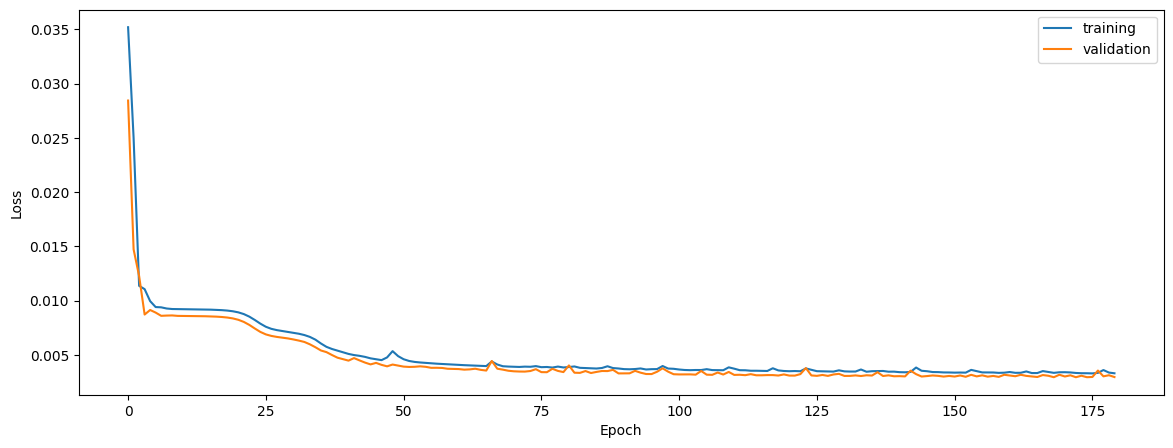

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8022872851410542
0.8116996420560572
0.800824850181043


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8039692281926785
0.8263093792017783
0.8065202067344011


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8027237541328279
0.8233710472853041
0.8023225227013583


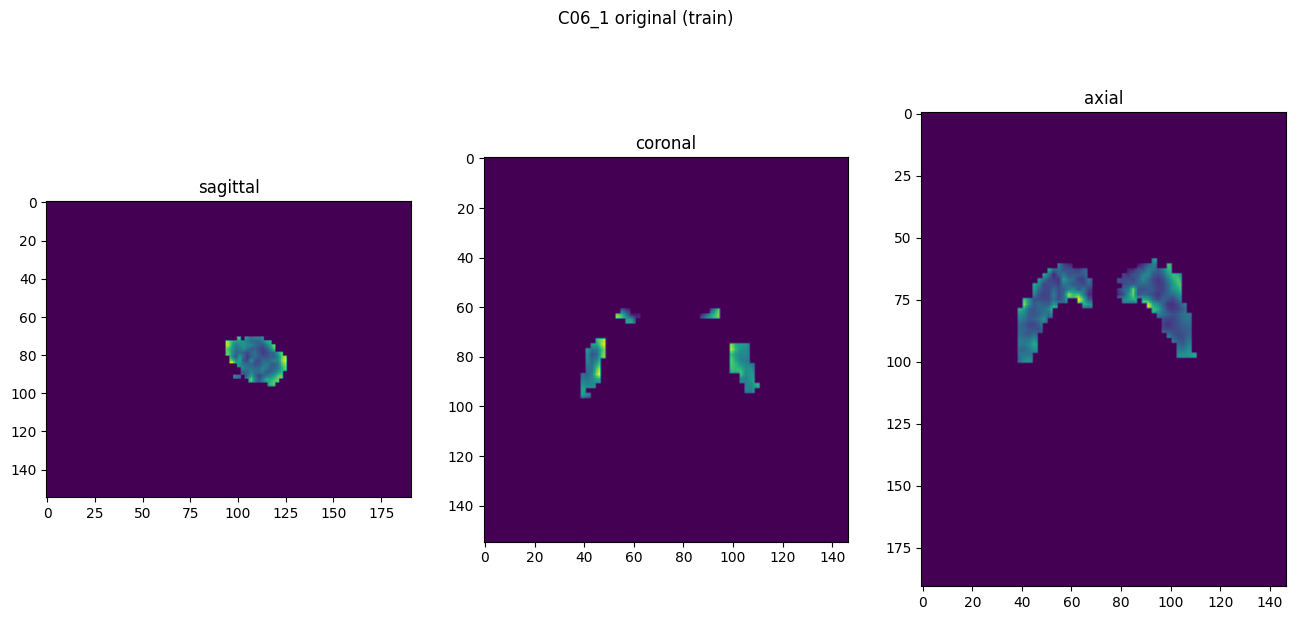

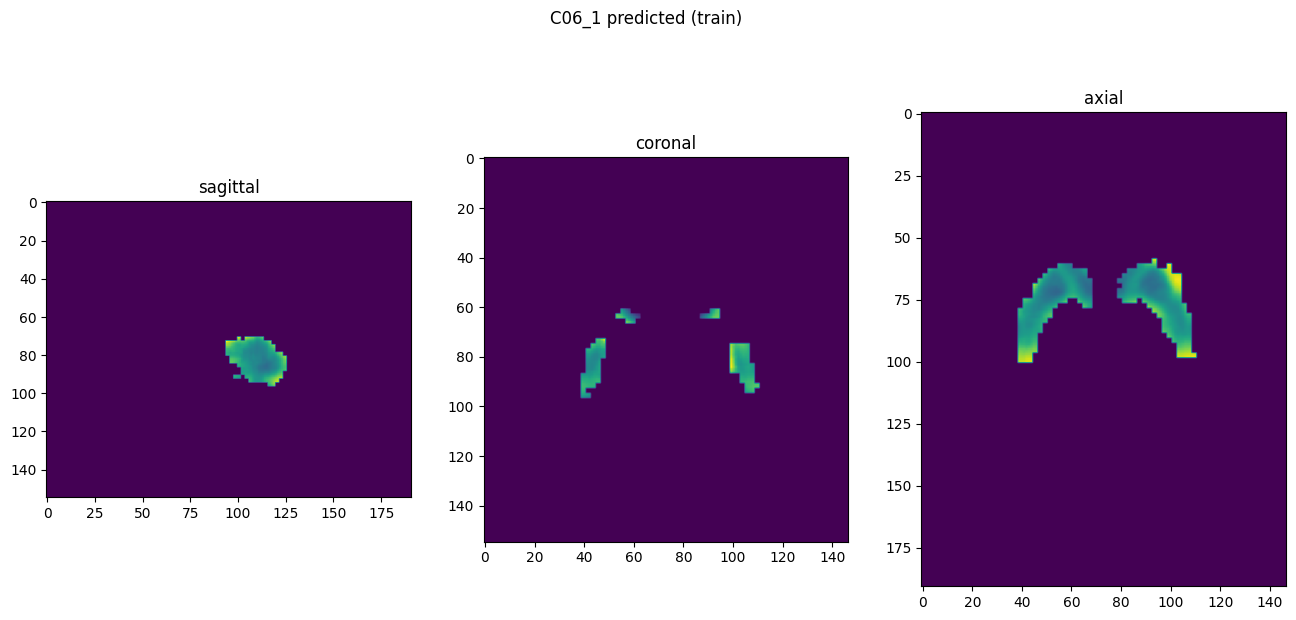

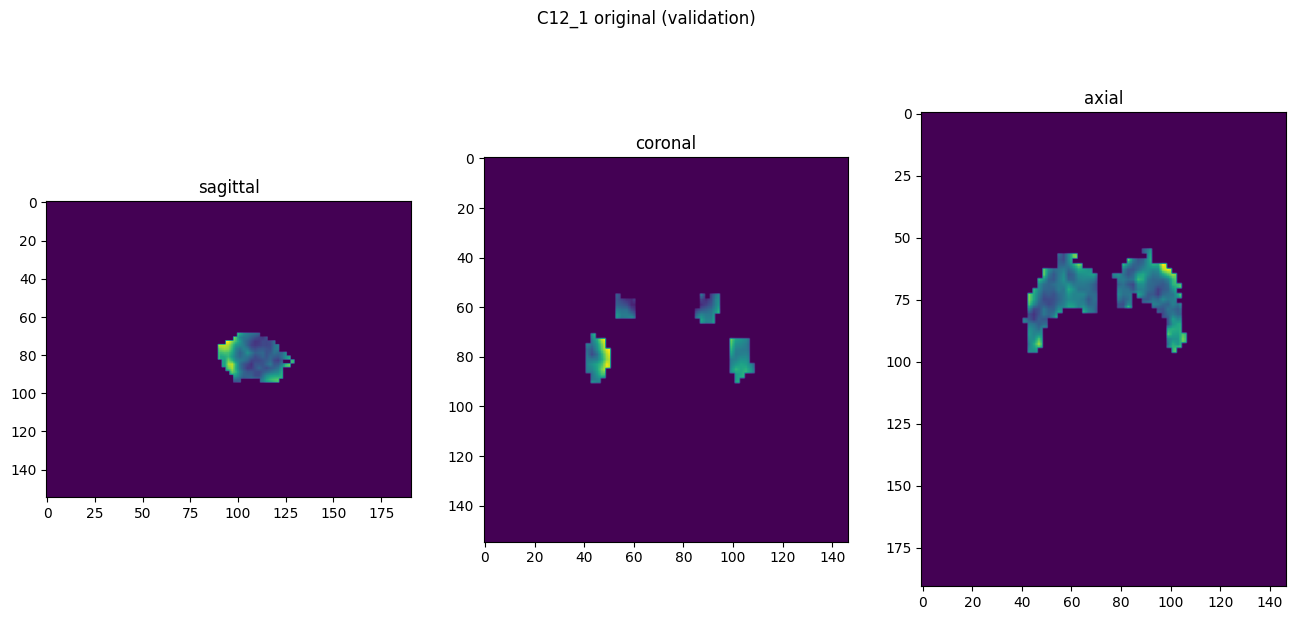

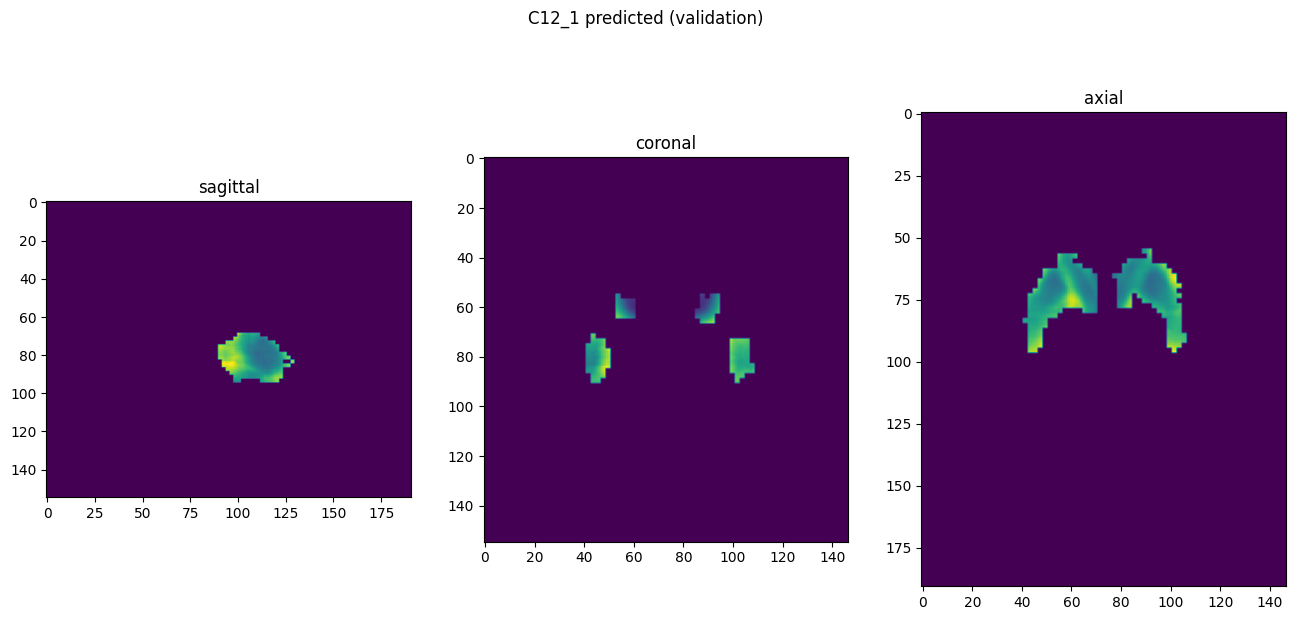

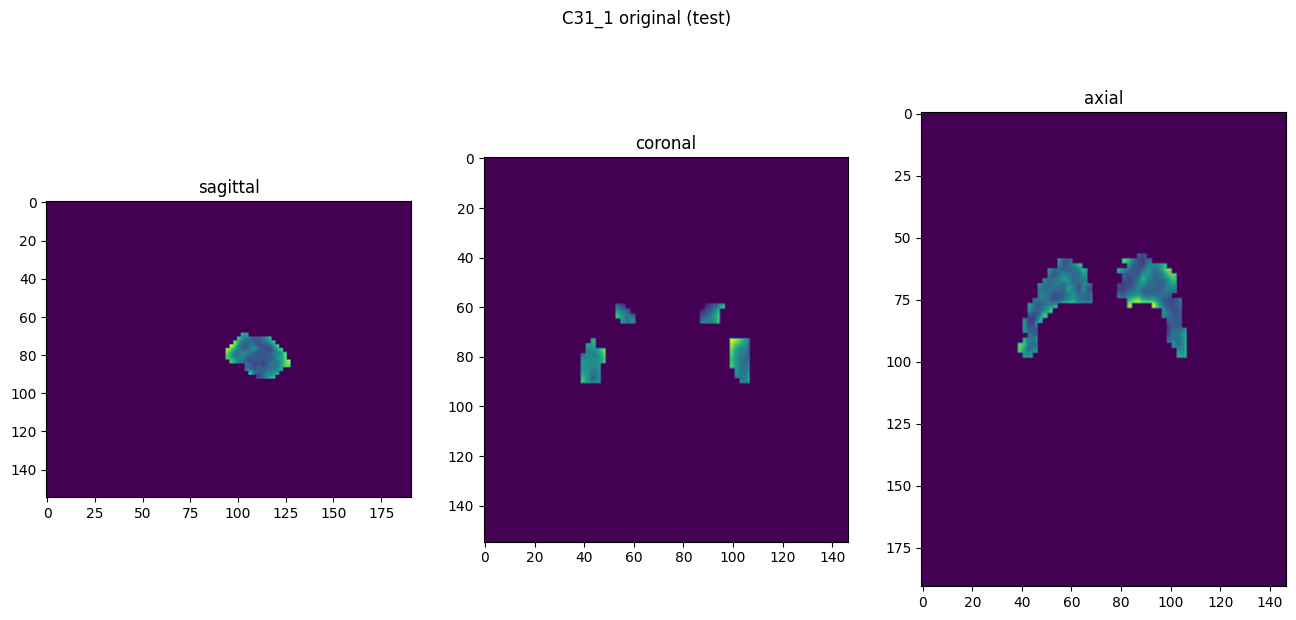

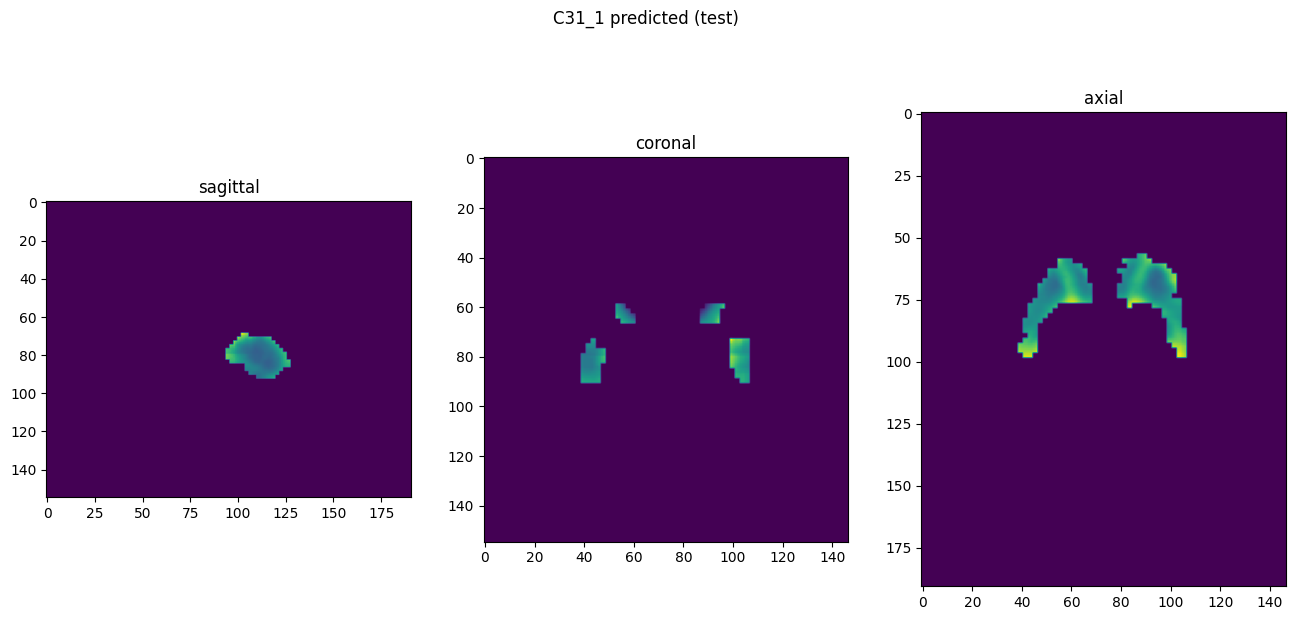

In [10]:
showResults(model, gen, threshold=None, background=False)